In [ ]:
import json
import glob
import os
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================

LOG_DIRECTORIES = "/lustre/groups/eml/projects/huang/multi_image/lmms-eval/logs/llava-ov-mask-attention"
# ==========================================
# 2. DATA EXTRACTION
# ==========================================

def get_primary_score(metrics):
    """Finds the first float value that isn't stderr/alias."""
    for key, val in metrics.items():
        if isinstance(val, (int, float)) and "stderr" not in key and "alias" not in key:
            return val * 100
    return None

all_rows = []

# Iterate through directories
# Find all JSON results recursively
search_pattern = os.path.join(LOG_DIRECTORIES, "**", "*_results.json")
files = glob.glob(search_pattern, recursive=True)

for file_path in files:
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except:
        continue

    # 1. Identify Model
    model_name = data.get('model_name_sanitized', data.get('model_name', 'Unknown'))
    model_name = model_name.split("__")[1]
    # The layer is the part after -mask-attention- 
    layer = file_path.split("/")[-3].split("-mask-attention-")[-1]
    row = {
        'Model': model_name,
        'Masked Layers': layer
    }

    # 2. Extract Scores
    results = data.get('results', {})
    
    for task, metrics in results.items():
        score = get_primary_score(metrics)
        
        if score is None: continue

        # Map to readable column names
        if task == 'blink':
            row['BLINK'] = score
        elif task == 'mirb':
            row['MIRB'] = score
        elif task == 'muirbench':
            row['MuirBench'] = score
        elif task.startswith('blink_'):
            # Clean subtask name: blink_art_style -> Art Style
            clean_name = task.replace('blink_', '').replace('_', ' ').title()
            row[clean_name] = score
    
    if len(row) > 2: # Only add if we found some metrics
        all_rows.append(row)

# ==========================================
# 3. DATAFRAME CREATION
# ==========================================

if all_rows:
    df = pd.DataFrame(all_rows)
    
    # Sort by Model first (versions together), then Experiment
    df = df.sort_values(by=['Model', 'Masked Layers']).reset_index(drop=True)
    # Reorder the DataFrame so that 'Baseline' and 'all' rows come first,
    # followed by individual mask layers (single numbers), then grouped ranges.

    # Helper function to create a sorting key for 'Masked Layers'
    import re

    def masked_layer_sort_key(x):
        # Put 'baseline' and 'all' at the very top
        x_lower = str(x).lower()
        if x_lower == 'baseline' or x_lower == 'all':
            return (0, 0, 0)
        # Individual layer: just a single integer (e.g. '0', '5')
        if re.fullmatch(r'\d+', str(x)):
            return (1, int(x), 0)
        # Grouped range: e.g. '0-3', '4-7'
        m = re.fullmatch(r'(\d+)\-(\d+)', str(x))
        if m:
            return (2, int(m.group(1)), int(m.group(2)))
        # Other: put at end
        return (3, 0, 0)

    df = df.copy()
    df['__ml_sortkey'] = df['Masked Layers'].map(masked_layer_sort_key)
    df = df.sort_values(by=['Model', '__ml_sortkey']).reset_index(drop=True)
    df = df.drop(columns="__ml_sortkey")
    
    
    

    # --- TABLE 1: MAIN BENCHMARKS ---
    main_benchmarks = ['BLINK', 'MIRB', 'MuirBench']
    
    # Filter columns that actually exist in the data
    valid_main_cols = [c for c in main_benchmarks if c in df.columns]
    
    if valid_main_cols:
        # Create Main DataFrame
        df_main = df[['Model', 'Masked Layers'] + valid_main_cols].copy()
        
        print("\n### 1. Main Benchmark Results")
        # Apply 'Blues' colormap: Darker = Higher Value
        display(
            df_main.style.format(precision=1, na_rep="-")
            .background_gradient(cmap='Blues', subset=valid_main_cols)
            .set_properties(**{'text-align': 'center'})
        )

    # --- TABLE 2: BLINK SUBTASKS ---
    # Identify subtask columns (cols not in main benchmarks and not metadata)
    meta_cols = ['Model', 'Masked Layers']
    subtask_cols = [c for c in df.columns if c not in main_benchmarks and c not in meta_cols]
    subtask_cols.sort()
    
    if subtask_cols:
        # Create Subtask DataFrame
        df_blink = df[meta_cols + subtask_cols].copy()
        
        print("\n### 2. BLINK Subtask Breakdown")
        # You can keep this one different (e.g., Greens) or same (Blues)
        display(
            df_blink.style.format(precision=1, na_rep="-")
            .background_gradient(cmap='Blues', subset=subtask_cols)
            .set_properties(**{'text-align': 'center'})
        )

else:
    print("No data found.")


### 1. Main Benchmark Results



### 2. BLINK Subtask Breakdown


Bad pipe message: %s [b'\r\nunleash-appname: codeium-extension\r\nUNLEASH-INSTANCEID: leander.girrbach-supergpu15.scidom.de\r\nIf-None-Match']
Bad pipe message: %s [b'W/"55f04-2vtfQwJp96ws-hq6EHpKew=="\r\nUnleash-Client-Spec: ']
Bad pipe message: %s [b'2.0\r\nunleash-sdk: unleash-node-sdk:6.7.0\r\nAuthorizat']
Bad pipe message: %s [b'n: *:production.853c3f3dde009b1db67a70e1de9cfff6e3e373524f451b88b8846542\r\nunleash-connection-id: facc439', b'02d1-472b-8755-52bbde10ec6e\r\nunleash-interval: 60000\r\nAccept: */*\r\nAccept-Encoding: gzip,deflate', b'Host: localh']
Bad pipe message: %s [b't:8185\r\nsentry-trace: f05edb2e527345de8c1951f028bac2fa-9c4e9c215079af5b\r\nbaggage: sentry-environment=productio', b'sentry-release=vscode-marimo%400.9.13,sentry-public_key=717e07e6f9831ef39f872ab4a7a63dc2,sentry-trace_id=f05e']
Bad pipe message: %s [b'\r\nunleash-appname: codeium-extension\r\nUNLEASH-INSTANCEID: leander.girrbach-supergpu15.scidom.de\r\nIf-None-Match']
Bad pipe message: %s [b'W/"55f04-

Bad pipe message: %s [b'\r\nunleash-appname: codeium-extension\r\nUNLEASH-INSTANCEID: leander.girrbach-supergpu15.scidom.de\r\nIf-None-Match']
Bad pipe message: %s [b'W/"55f04-2vtfQwJp96ws-hq6EHpKew=="\r\nUnleash-Client-Spec: ']
Bad pipe message: %s [b'2.0\r\nunleash-sdk: unleash-node-sdk:6.7.0\r\nAuthorizat']
Bad pipe message: %s [b'n: *:production.853c3f3dde009b1db67a70e1de9cfff6e3e373524f451b88b8846542\r\nunleash-connection-id: facc439', b'02d1-472b-8755-52bbde10ec6e\r\nunleash-interval: 60000\r\nAccept: */*\r\nAccept-Encoding: gzip,deflate', b'Host: localh']
Bad pipe message: %s [b't:8185\r\nsentry-trace: f05edb2e527345de8c1951f028bac2fa-a31bf5d21b811e56\r\nbaggage: sentry-environment=productio', b'sentry-release=vscode-marimo%400.9.13,sentry-public_key=717e07e6f9831ef39f872ab4a7a63dc2,sentry-trace_id=f05e']
Bad pipe message: %s [b'-appname: codeium-extension\r\nUNLEASH-INSTANCEID: leander.girrbach-supergpu15.scidom.de\r\nContent-Type: application/']
Bad pipe message: %s [b'on\r\nu

Bad pipe message: %s [b'\r\nunleash-appname: codeium-extension\r\nUNLEASH-INSTANCEID: leander.girrbach-supergpu15.scidom.de\r\nIf-None-Match']
Bad pipe message: %s [b'W/"55f04-2vtfQwJp96ws-hq6EHpKew=="\r\nUnleash-Client-Spec: ']
Bad pipe message: %s [b'2.0\r\nunleash-sdk: unleash-node-sdk:6.7.0\r\nAuthorizat']
Bad pipe message: %s [b'\r\nunleash-appname: codeium-extension\r\nUNLEASH-INSTANCEID: leander.girrbach-supergpu15.scidom.de\r\nIf-None-Match']
Bad pipe message: %s [b'n: *:production.853c3f3dde009b1db67a70e1de9cfff6e3e373524f451b88b8846542\r\nunleash-connection-id: facc439', b'02d1-472b-8755-52bbde10ec6e\r\nunleash-interval: 60000\r\nAccept: */*\r\nAccept-Encoding: gzip,deflate', b'Host: localh']
Bad pipe message: %s [b'W/"55f04-2vtfQwJp96ws-hq6EHpKew=="\r\nUnleash-Client-Spec: ']
Bad pipe message: %s [b't:8185\r\nsentry-trace: f05edb2e527345de8c1951f028bac2fa-84167e6225c0b652\r\nbaggage: sentry-environment=productio', b'sentry-release=vscode-marimo%400.9.13,sentry-public_key=717

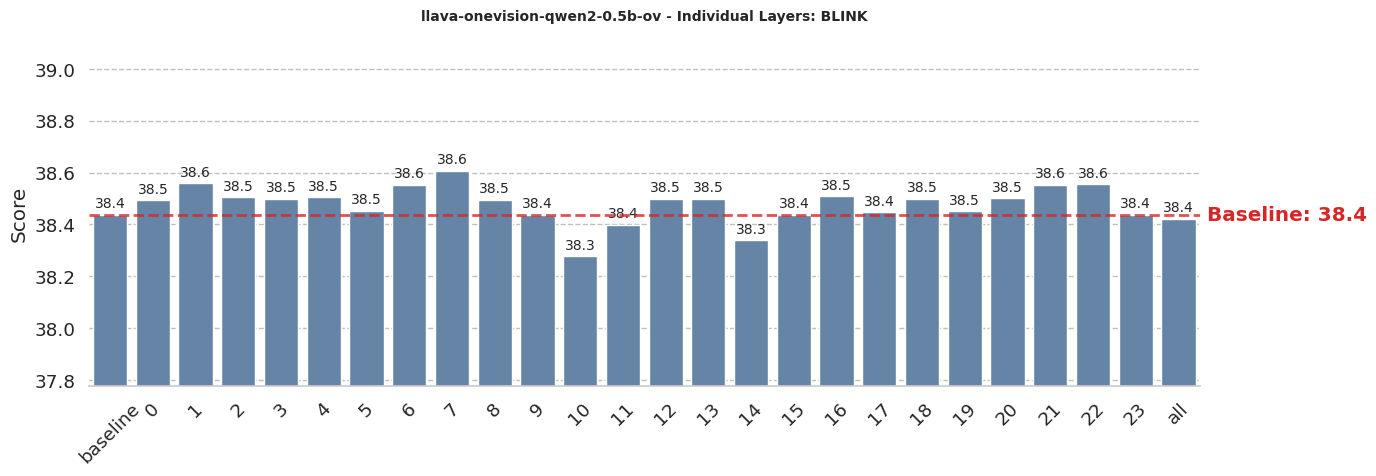

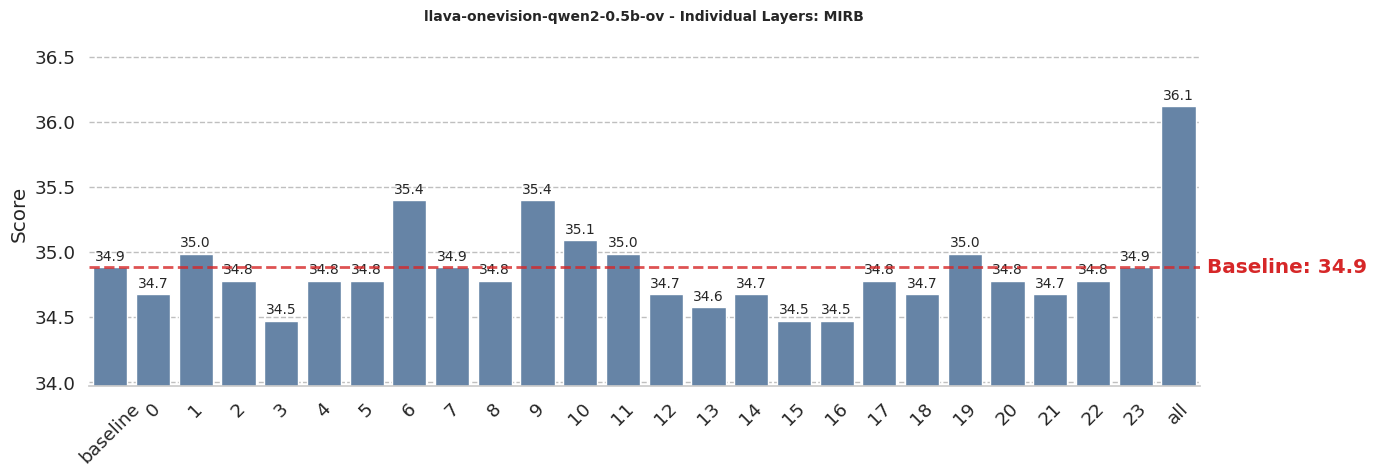

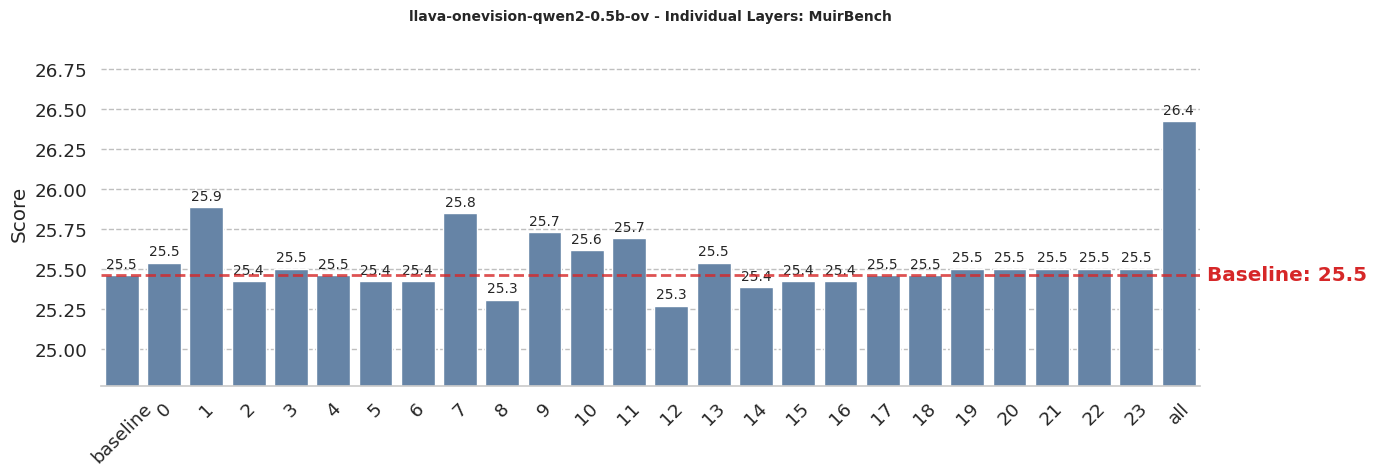

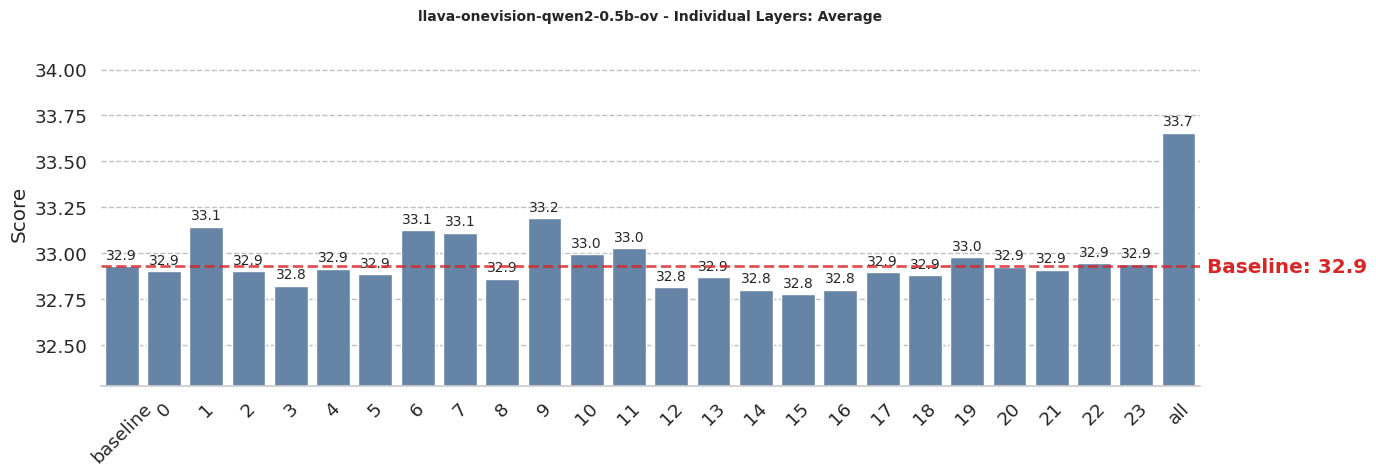

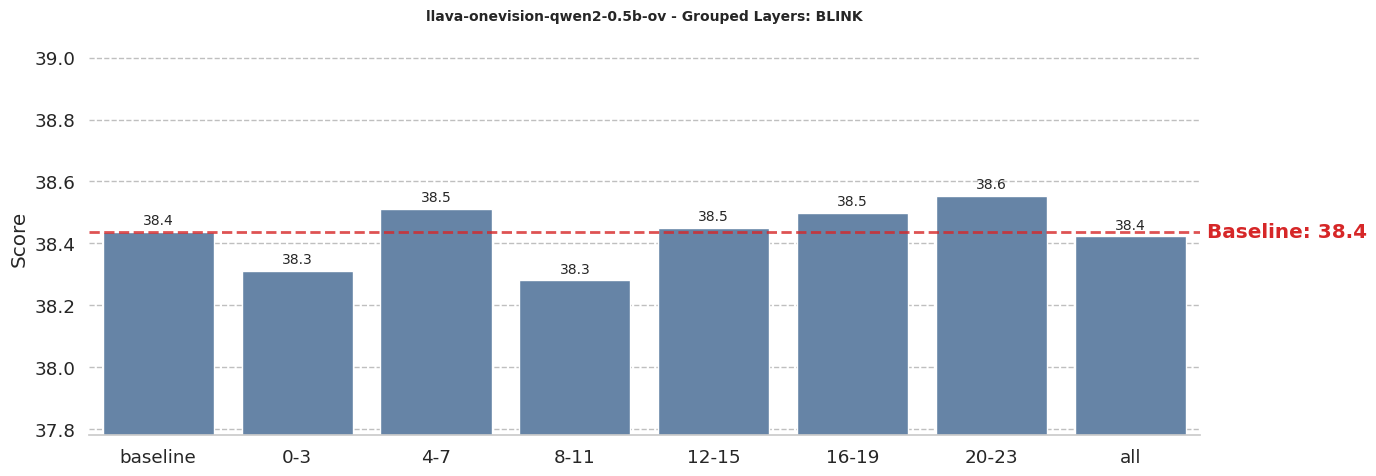

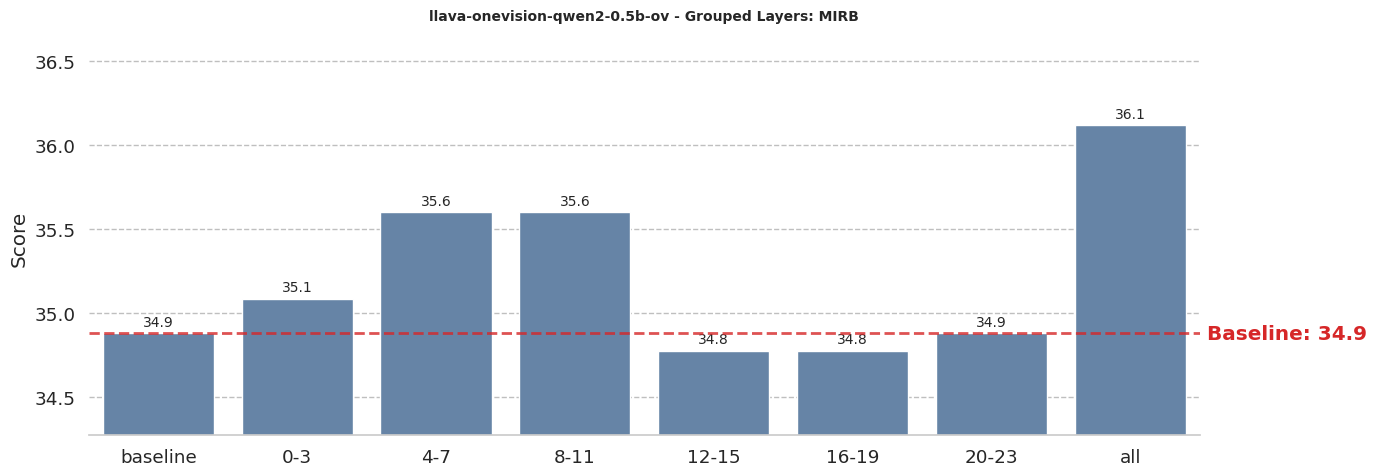

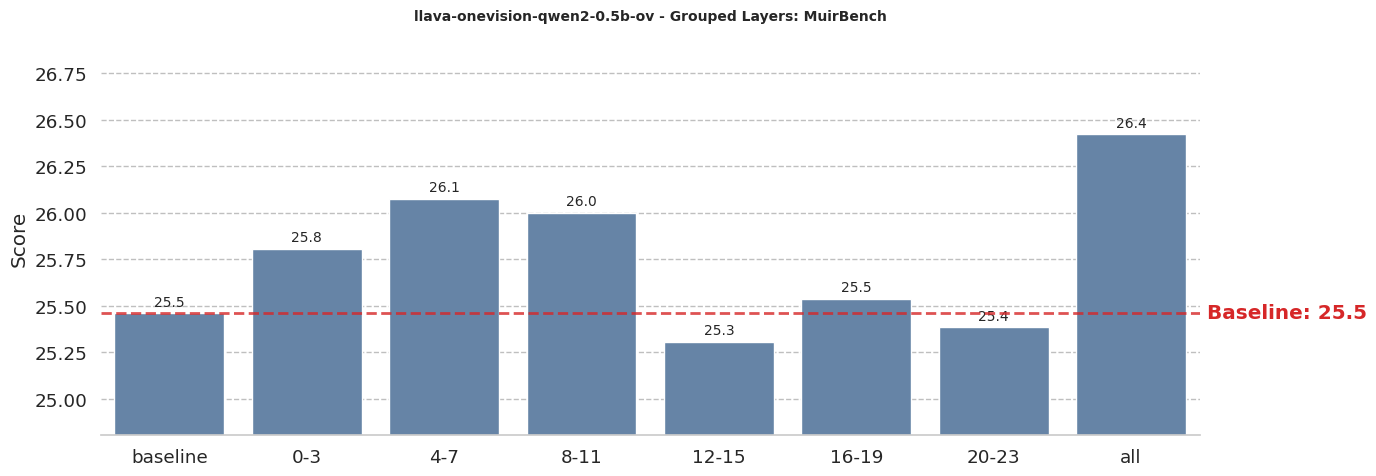

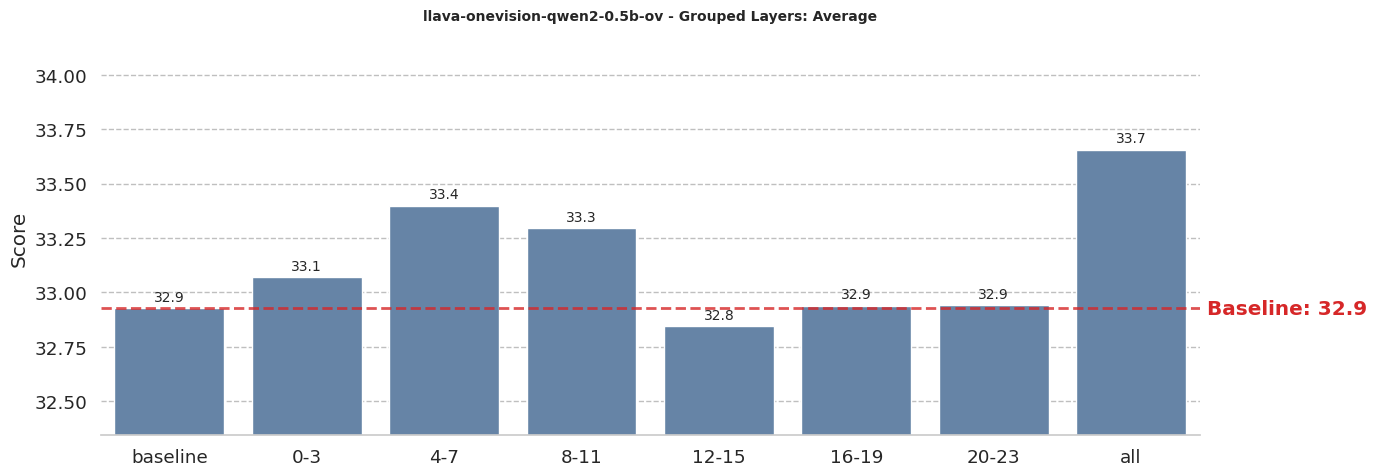

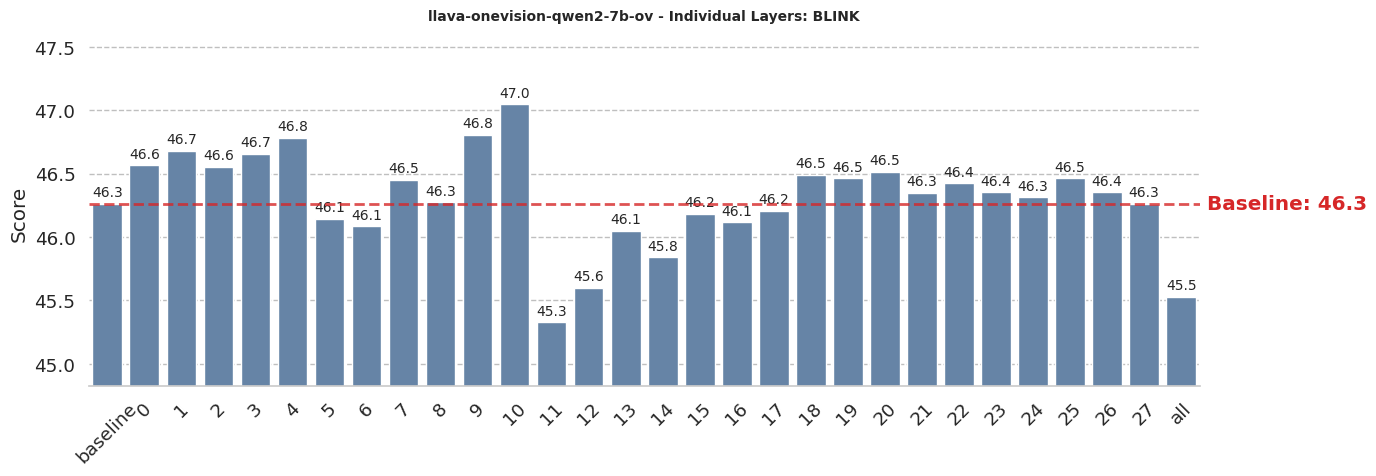

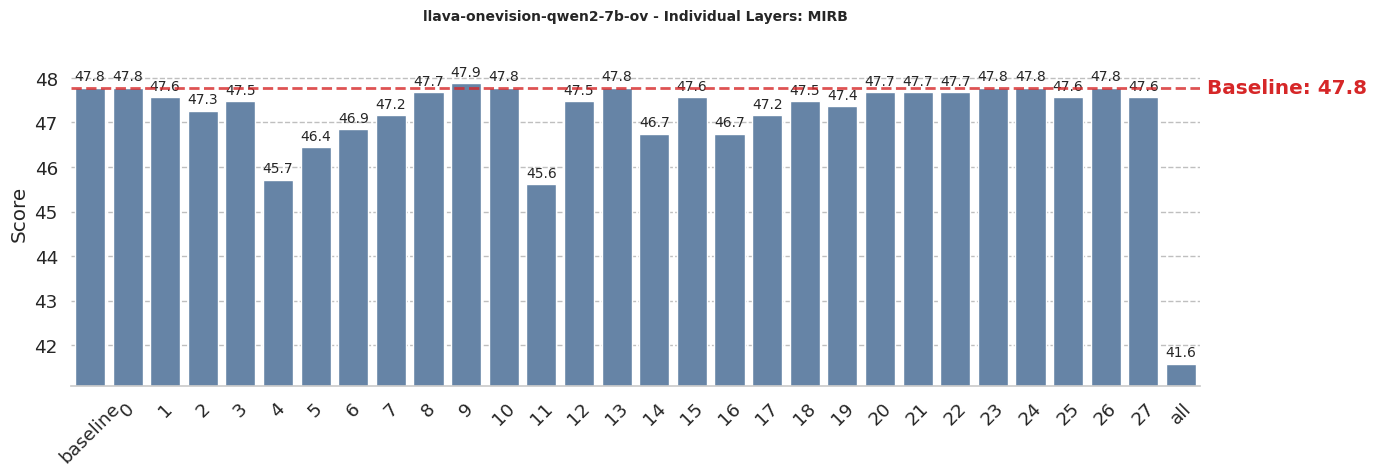

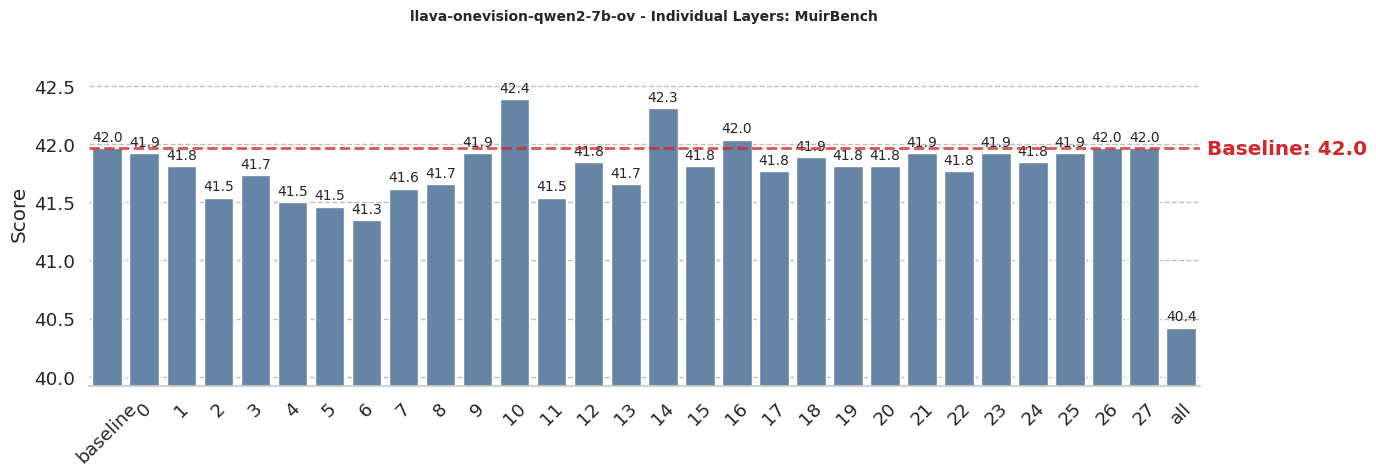

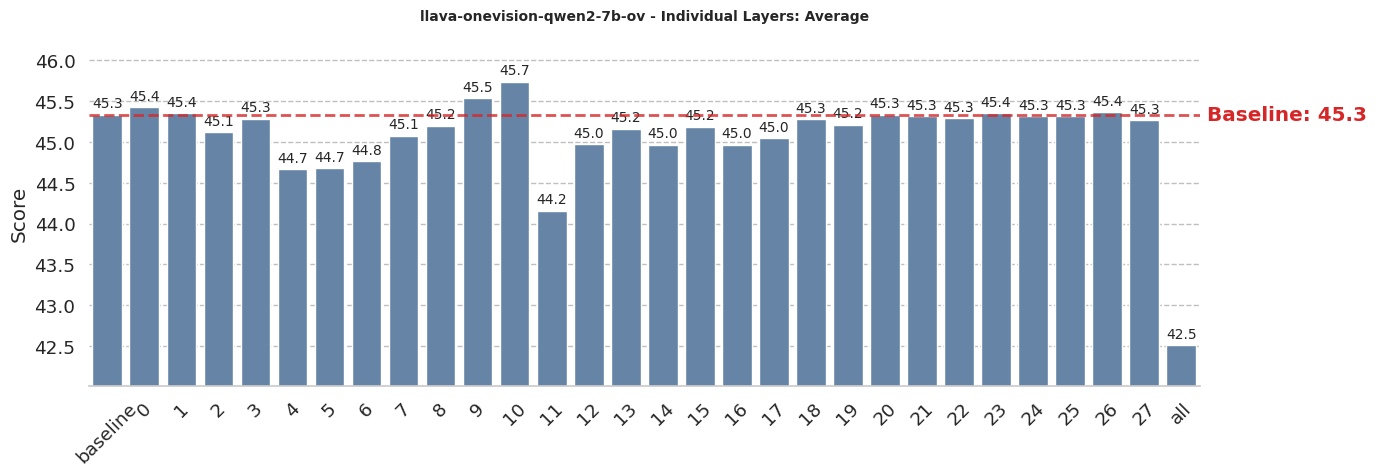

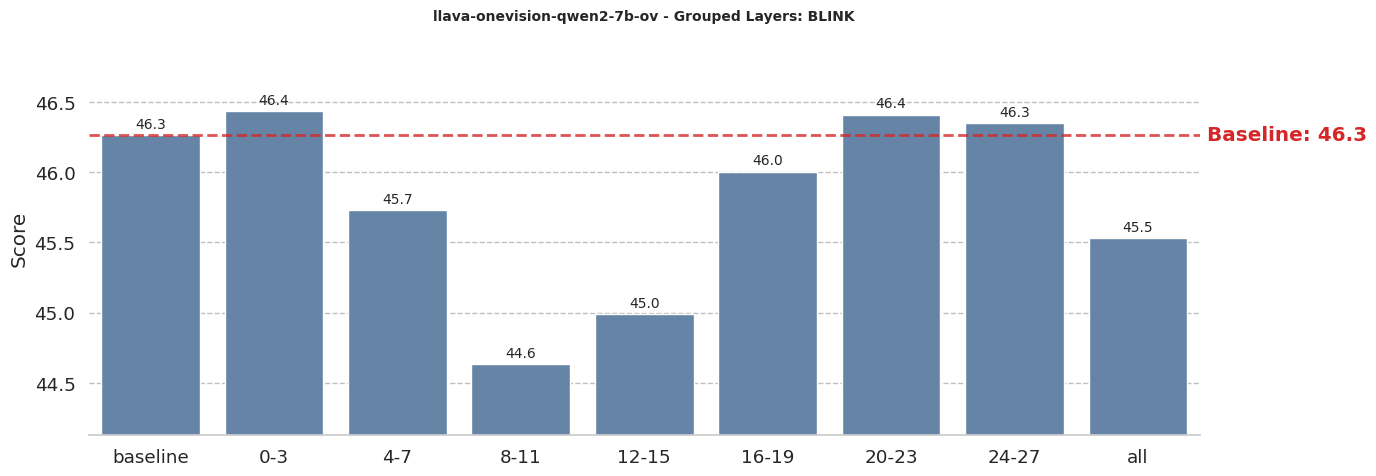

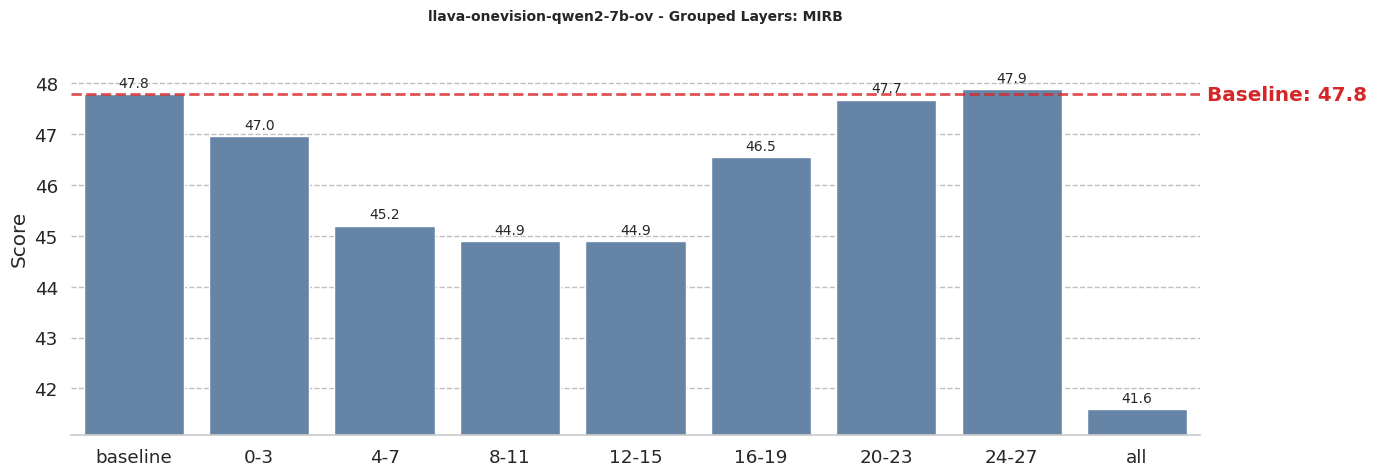

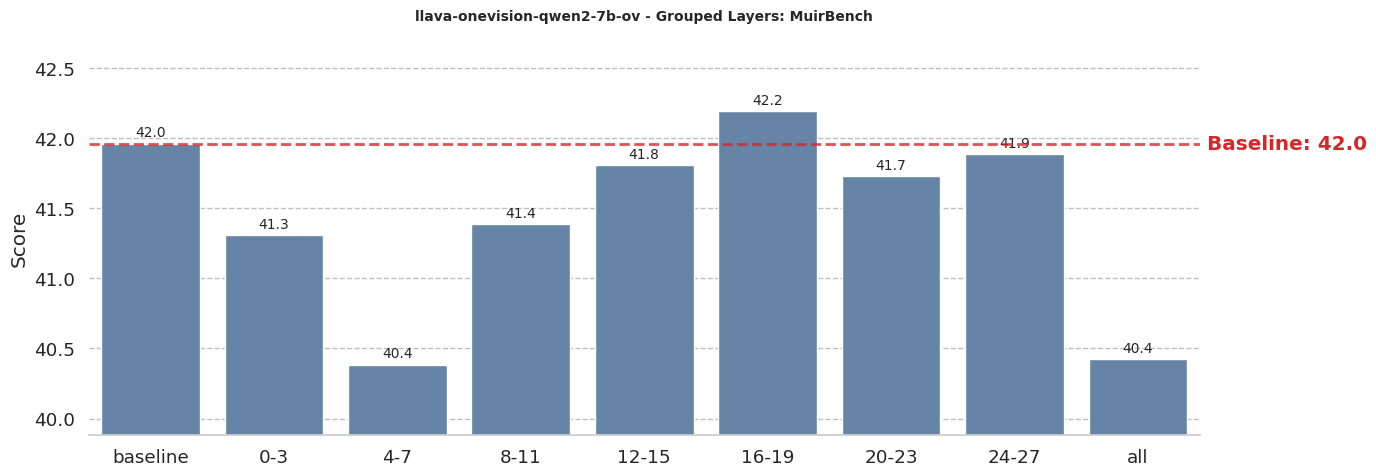

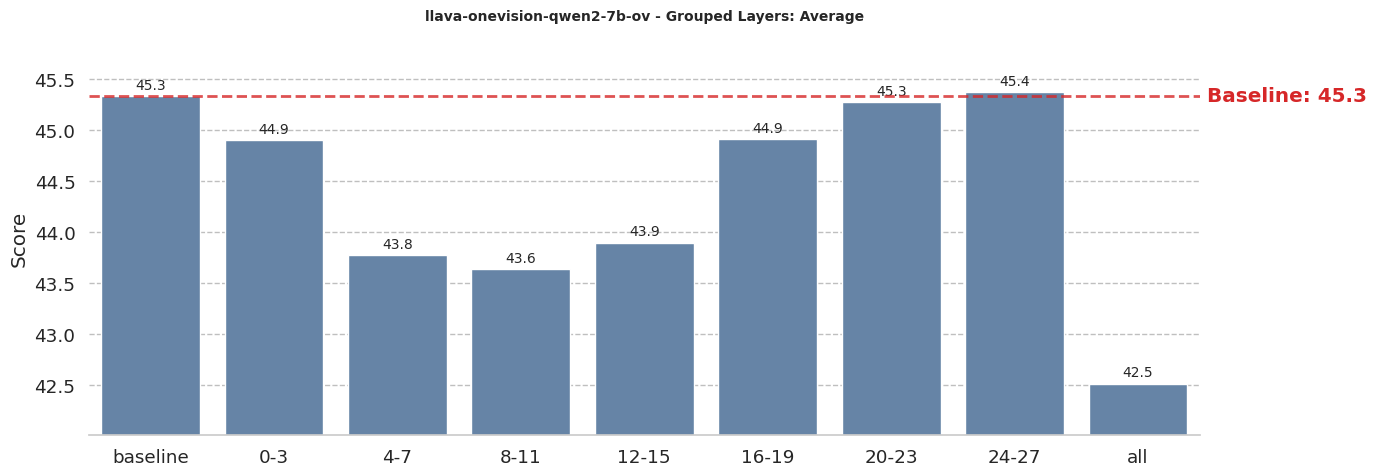

Bad pipe message: %s [b'-appname: codeium-extension\r\nUNLEASH-INSTANCEID: leander.girrbach-supergpu15.scidom.de\r\nContent-Type: application/']
Bad pipe message: %s [b'on\r\nunleash-sdk: unleash-node-sdk:6.7.0\r\nAuthorization: *:production.853c3f3dde009b1db67a70e1de9cfff6e3e3', b'524f451b88b8846542\r\nunleash-connection-id: facc439a-02', b'-472b-8755-52bbde10ec6e\r\nunleash-interval: 60000\r\nAccept: */*\r\nContent-Length: 470\r\nAccept-Encoding', b'gzip,deflate\r\nHost: localhost:8185\r\nsentry-trace: f05edb2']
Bad pipe message: %s [b'27345de8c1951f028bac2fa-bf3a163bc32612e1\r\nbaggage: sentry-environment=production,sentry-release=vsco', b'-marimo%400.9.13,sentry-public_key=717e07e6f9831ef39f872ab4a7a63dc2,sentry-trace_id=f05edb2e527345d', b'c1951f028bac2fa,sentry-org_id=4505919839862784\r\nConnection: close\r\n\r\n{"appName":"codeium-extension",']
Bad pipe message: %s [b'nstanceId":"leander.girrbach-supe', b'pu15.scidom.de","connectionId":"facc439a-02d1-472b-8755-52bbde10ec6e","buc

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ==========================================
# 4. PLOTTING (Separate Figures + Value Labels)
# ==========================================

if 'df' in locals() and not df.empty:

    # --- Configuration ---
    sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2)
    
    # Define metrics to plot
    main_benchmarks = ['BLINK', 'MIRB', 'MuirBench']
    valid_metrics = [m for m in main_benchmarks if m in df.columns]
    
    if valid_metrics:
        # Recalculate Average
        df['Average'] = df[valid_metrics].mean(axis=1)
        plot_metrics = valid_metrics + ['Average']
    else:
        print("No valid metrics found to plot.")
        plot_metrics = []

    # --- Sorting Logic ---
    def get_sort_key(val):
        s_val = str(val).strip().lower()
        if 'baseline' in s_val: return (0, -1)   # Priority 0: Baseline
        if s_val == 'all': return (3, 999)       # Priority 3: All (Last)
        
        if '-' in s_val:
            try:
                start = int(s_val.split('-')[0])
                return (2, start)                # Priority 2: Ranges
            except: pass
            
        if s_val.isdigit():
            return (1, int(s_val))               # Priority 1: Singles
            
        return (4, 0)

    df['sort_key'] = df['Masked Layers'].apply(get_sort_key)

    # --- Plotting Loop ---
    unique_models = df['Model'].unique()

    for model in unique_models:
        model_df = df[df['Model'] == model].copy()

        # Create two subsets
        # 1. Individual Layers
        mask_singles = model_df['sort_key'].apply(lambda x: x[0] in [0, 1, 3])
        df_singles = model_df[mask_singles].sort_values('sort_key')

        # 2. Grouped Layers
        mask_ranges = model_df['sort_key'].apply(lambda x: x[0] in [0, 2, 3])
        df_ranges = model_df[mask_ranges].sort_values('sort_key')

        datasets = [
            (df_singles, "Individual Layers"),
            (df_ranges, "Grouped Layers")
        ]

        for data, subtitle in datasets:
            if len(data) <= 1: continue

            for metric in plot_metrics:
                
                plt.figure(figsize=(14, 5)) # New figure for every plot
                
                # 1. Extract Baseline Value
                baseline_row = data[data['Masked Layers'].astype(str).str.contains('Baseline', case=False)]
                baseline_val = baseline_row[metric].values[0] if not baseline_row.empty else None

                # 2. Draw Bar Chart
                ax = sns.barplot(
                    data=data,
                    x='Masked Layers',
                    y=metric,
                    color='#5b84b1',
                    edgecolor=None
                )

                # 3. Add Value Labels
                # -------------------------------------------------------
                for container in ax.containers:
                    ax.bar_label(container, fmt='%.1f', padding=3, fontsize=10)
                # -------------------------------------------------------

                # 4. Add Horizontal Baseline Line
                if baseline_val is not None:
                    plt.axhline(y=baseline_val, color='#d62728', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
                    # Add label near the right edge
                    plt.text(x=len(data)-0.5, y=baseline_val, s=f' Baseline: {baseline_val:.1f}', 
                             color='#d62728', va='center', ha='left', fontweight='bold')

                # 5. Smart Y-Axis Limits (Zoom in)
                y_values = data[metric].dropna().values
                if len(y_values) > 0:
                    y_min = y_values.min()
                    y_max = y_values.max()
                    
                    if baseline_val is not None:
                        y_min = min(y_min, baseline_val)
                        y_max = max(y_max, baseline_val)
                    
                    y_range = y_max - y_min
                    # 15% top margin to fit text, 5% bottom margin
                    top_margin = max(y_range * 0.15, 0.5)
                    bottom_margin = max(y_range * 0.05, 0.5)
                    
                    plt.ylim(y_min - bottom_margin, y_max + top_margin)

                # 6. Styling
                plt.title(f"{model} - {subtitle}: {metric}", fontsize=10, fontweight='bold', pad=15)
                plt.xlabel('')
                plt.ylabel('Score')
                sns.despine(left=True)
                plt.grid(axis='y', linestyle='--', alpha=0.5, color='gray')
                plt.grid(axis='x', visible=False)
                
                if 'Individual' in subtitle:
                    plt.xticks(rotation=45)

                plt.tight_layout()
                plt.show()

In [6]:
import json
import glob
import os
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================

LOG_DIRECTORIES = "/lustre/groups/eml/projects/huang/multi_image/lmms-eval/logs/llava-ov-mask-attention"

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================

def normalize_val(val):
    """Normalizes answers (e.g., '4.0' -> '4', 'Yes' -> 'yes')."""
    s = str(val).strip().lower()
    try:
        f_val = float(s)
        if f_val.is_integer():
            return str(int(f_val))
    except:
        pass
    return s

def calculate_acc(correct, total):
    return (correct / total * 100) if total > 0 else 0.0

def parse_muirbench(file_path):
    stats = {} 
    total_correct = 0
    total_count = 0
    
    try:
        with open(file_path, 'r') as f:
            for line in f:
                entry = json.loads(line)
                info = entry.get('muirbench_score_overall', {})
                if not info: continue
                
                task = info.get('task', 'Unknown')
                pred = normalize_val(info.get('pred', ''))
                ans  = normalize_val(info.get('answer', ''))
                
                is_correct = (pred == ans)
                
                # Update Subtask Stats
                if task not in stats: stats[task] = {'c': 0, 't': 0}
                stats[task]['t'] += 1
                if is_correct: stats[task]['c'] += 1
                
                # Update Overall Stats
                total_count += 1
                if is_correct: total_correct += 1
                
    except Exception as e:
        return None
        
    # Build Result Dict
    results = {k: calculate_acc(v['c'], v['t']) for k, v in stats.items()}
    results['Overall'] = calculate_acc(total_correct, total_count)
    return results

def parse_mirb(file_path):
    stats = {}
    total_correct = 0
    total_count = 0
    
    try:
        with open(file_path, 'r') as f:
            for line in f:
                entry = json.loads(line)
                info = entry.get('mirb_score', {})
                if not info: continue
                
                subset = info.get('subset', 'Unknown')
                
                # Handle List Predictions
                pred_raw = info.get('pred_answer', [])
                pred_val = pred_raw[0] if isinstance(pred_raw, list) and pred_raw else pred_raw
                
                pred = normalize_val(pred_val)
                ans  = normalize_val(info.get('answers', ''))
                
                is_correct = (pred == ans)
                
                # Update Subset Stats
                if subset not in stats: stats[subset] = {'c': 0, 't': 0}
                stats[subset]['t'] += 1
                if is_correct: stats[subset]['c'] += 1
                
                # Update Overall Stats
                total_count += 1
                if is_correct: total_correct += 1
                
    except Exception as e:
        return None
        
    # Build Result Dict
    results = {k: calculate_acc(v['c'], v['t']) for k, v in stats.items()}
    results['Overall'] = calculate_acc(total_correct, total_count)
    return results

# ==========================================
# 3. MAIN EXECUTION
# ==========================================

muir_rows = []

results_files = glob.glob(os.path.join(LOG_DIRECTORIES, "**", "*_results.json"), recursive=True)

for res_file in results_files:
    dir_name = os.path.dirname(res_file)
    base_name = os.path.basename(res_file).replace('_results.json', '')
    
    try:
        with open(res_file, 'r') as f:
            meta = json.load(f)
            model_name = meta.get('model_name_sanitized', meta.get('model_name', 'Unknown'))
    except:
        continue
        
    # MuirBench
    muir_path = os.path.join(dir_name, f"{base_name}_samples_muirbench.jsonl")
    layer = muir_path.split("/")[-3].split("-mask-attention-")[-1]
    if os.path.exists(muir_path):
        scores = parse_muirbench(muir_path)
        if scores:
            row = {'Model': model_name, 'Masked Layers': layer}
            row.update(scores)
            muir_rows.append(row)
                
        
# ==========================================
# 4. DISPLAY
# ==========================================

def display_table(data_rows, title):
    if not data_rows:
        return

    df = pd.DataFrame(data_rows)
    
    # 1. Sort Rows
    df = df.sort_values(by=['Model', 'Masked Layers']).reset_index(drop=True)
    
    # 2. Sort Columns
    meta = ['Model', 'Masked Layers']
    
    # Get all other columns
    others = [c for c in df.columns if c not in meta]
    
    # Force 'Overall' to be first, then sort the rest alphabetically
    if 'Overall' in others:
        others.remove('Overall')
        metrics = ['Overall'] + sorted(others)
    else:
        metrics = sorted(others)
        
    final_cols = meta + metrics
    df = df[final_cols]
    
    print(f"\n### {title}")
    display(
        df.style.format(precision=1, na_rep="-")
        .background_gradient(cmap='Blues', subset=metrics)
        .set_properties(**{'text-align': 'center'})
    )

display_table(muir_rows, "MuirBench Task Breakdown (with Overall)")


### MuirBench Task Breakdown (with Overall)


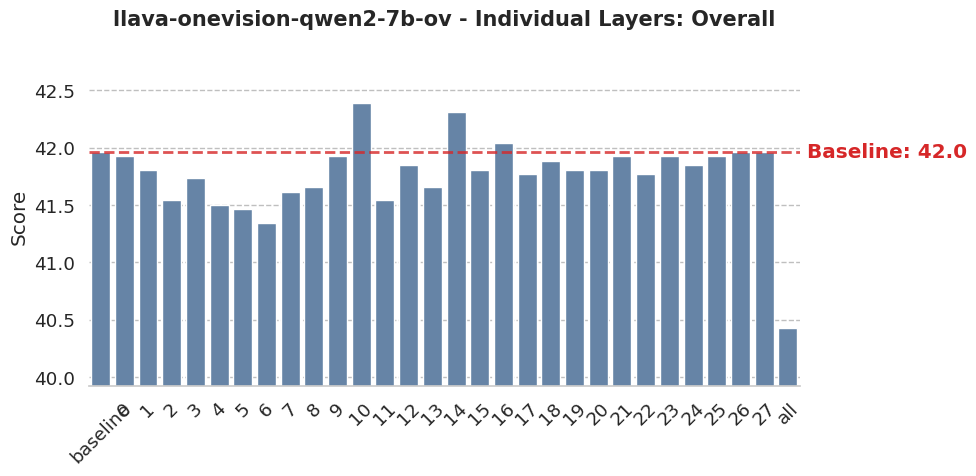

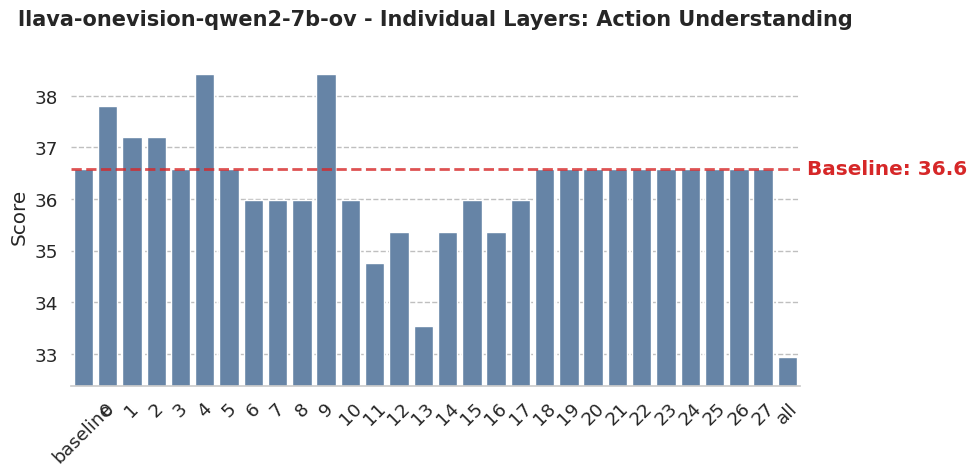

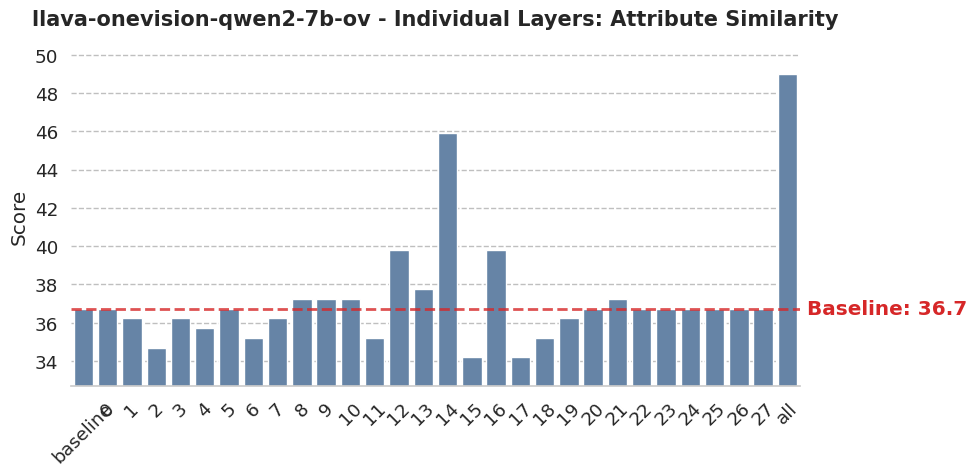

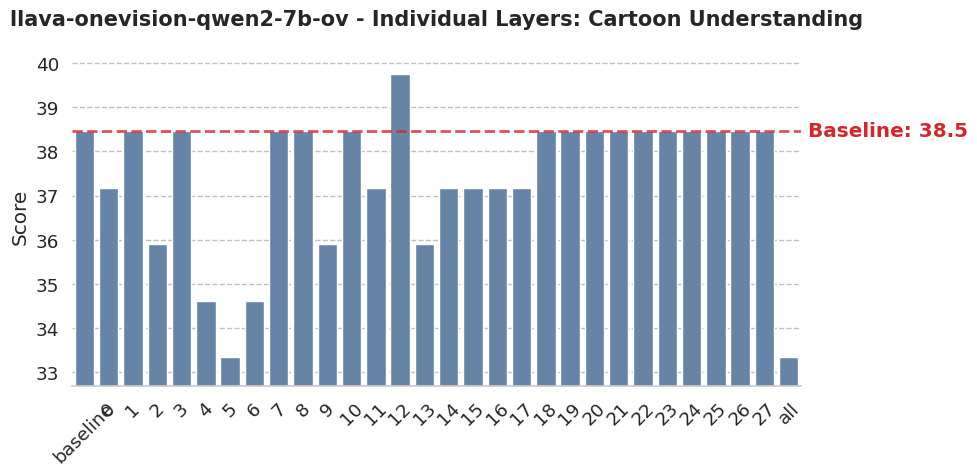

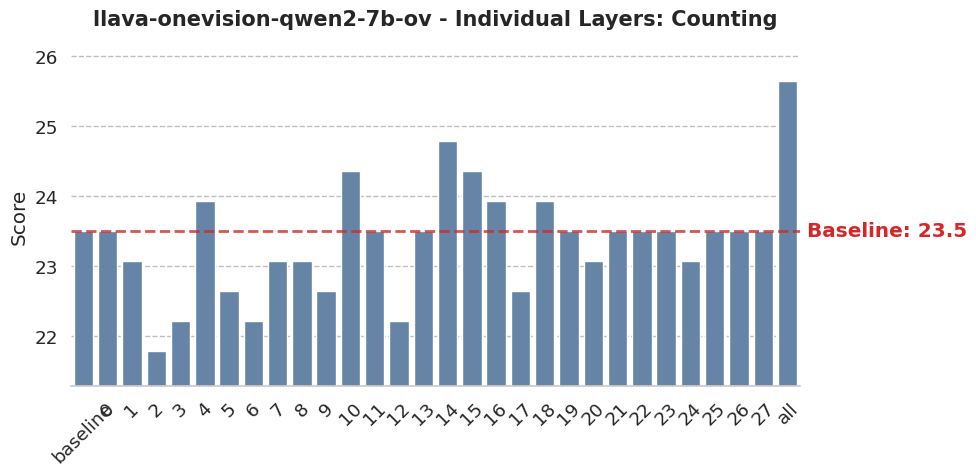

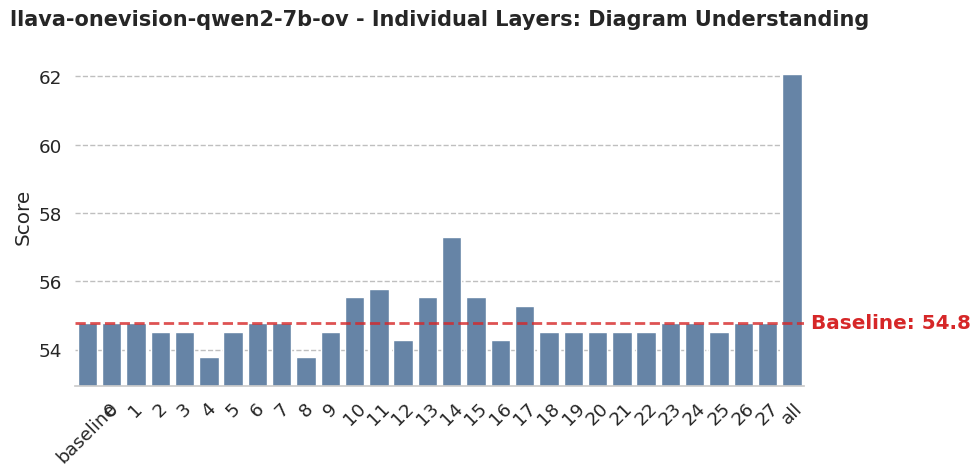

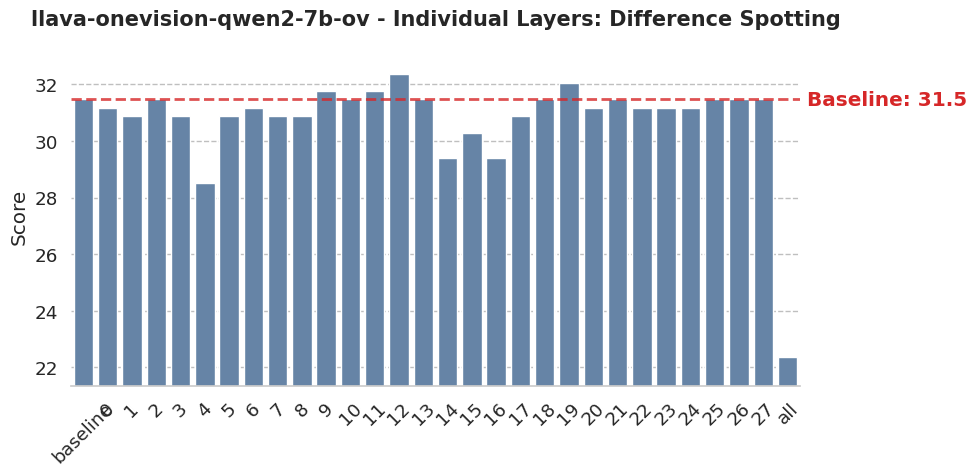

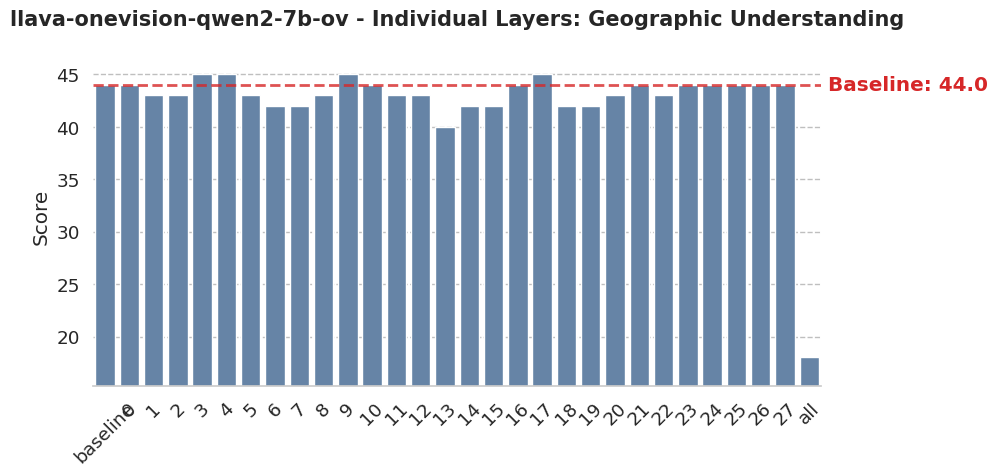

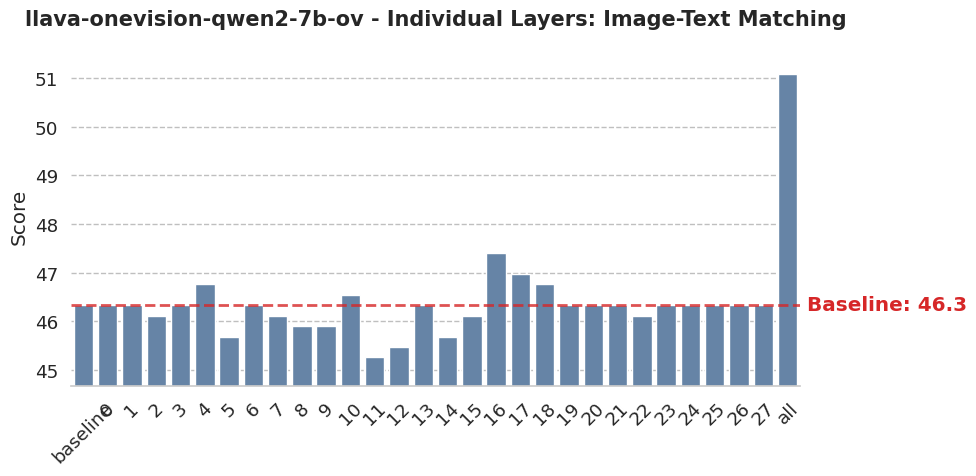

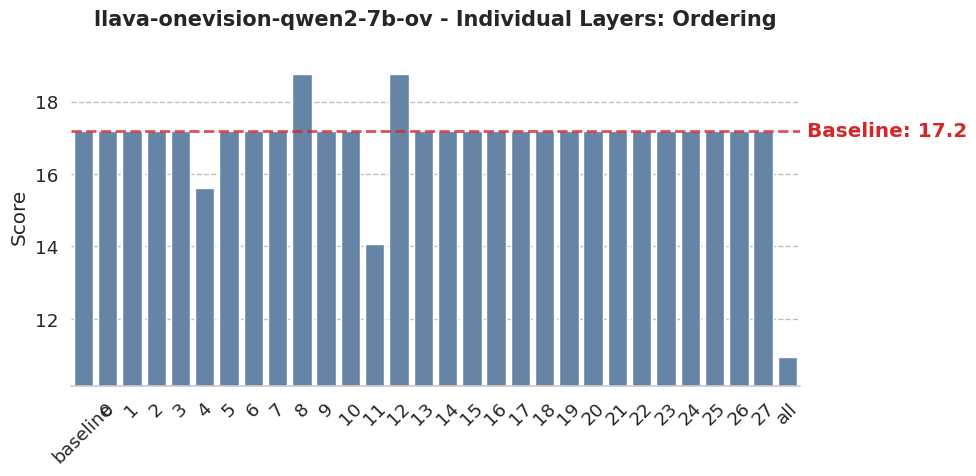

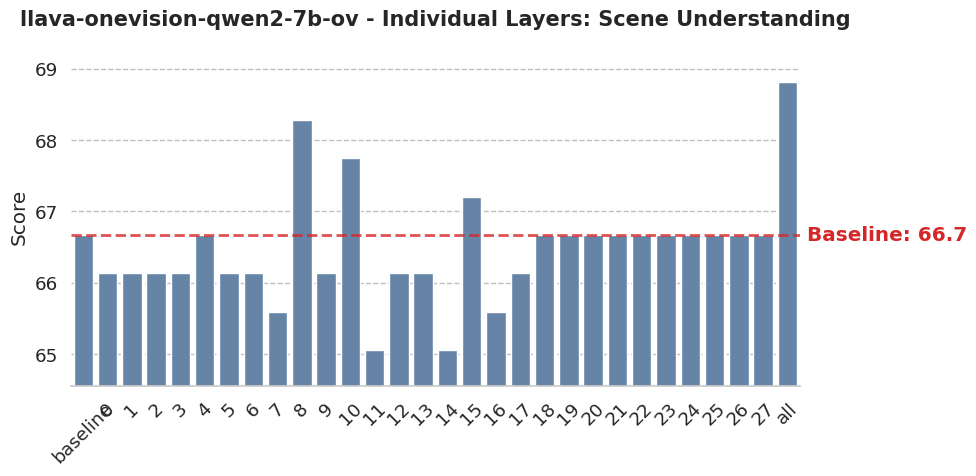

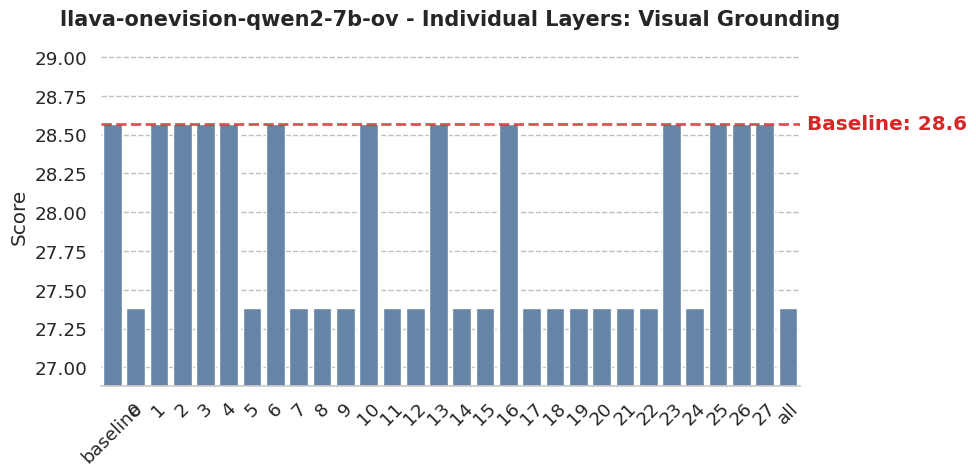

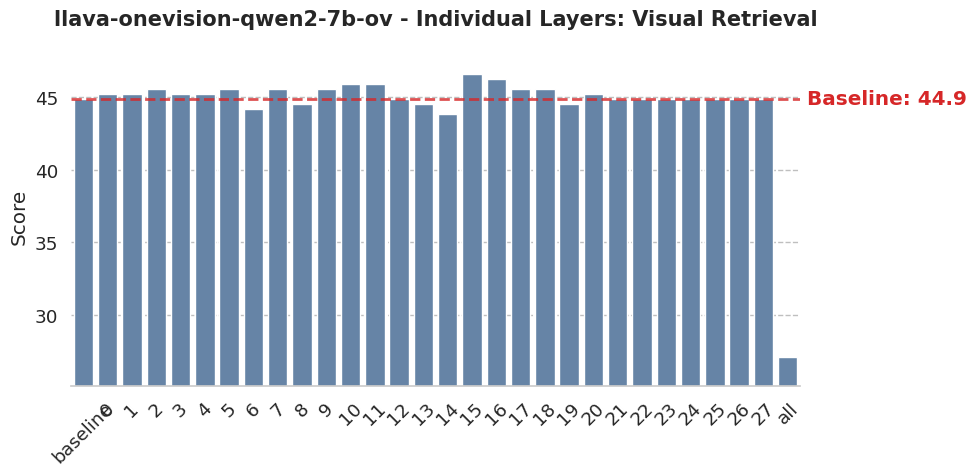

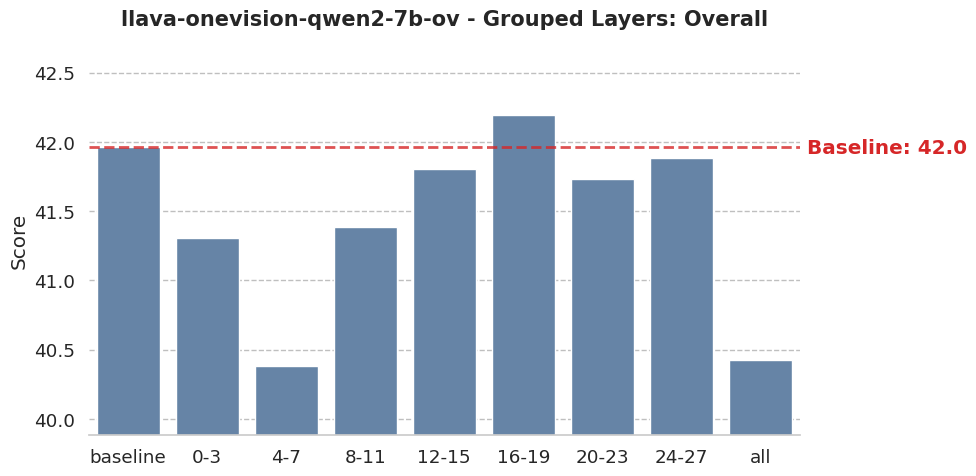

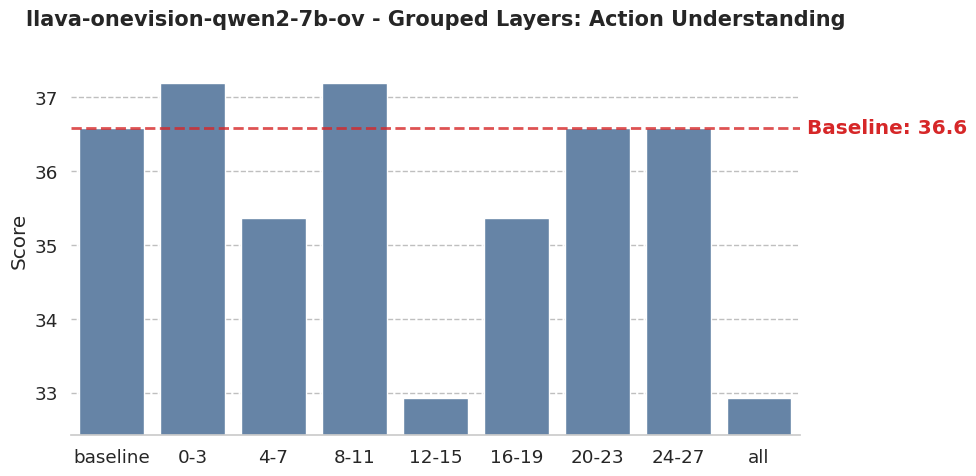

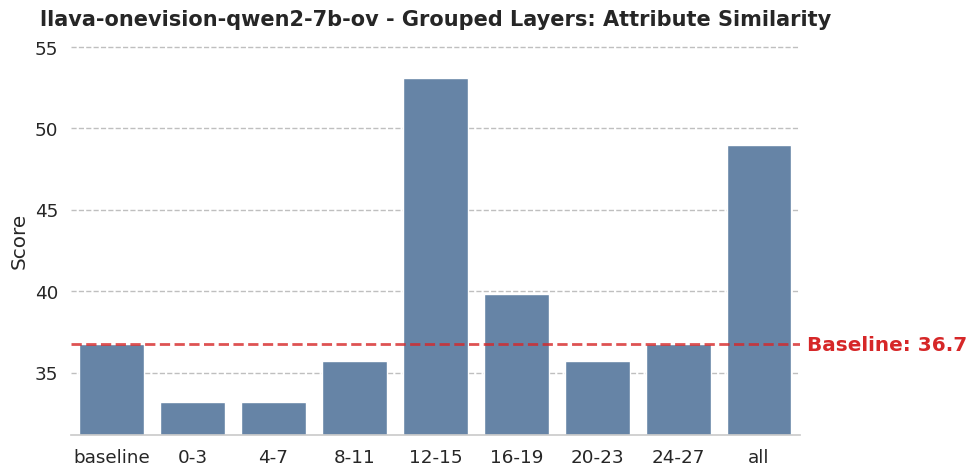

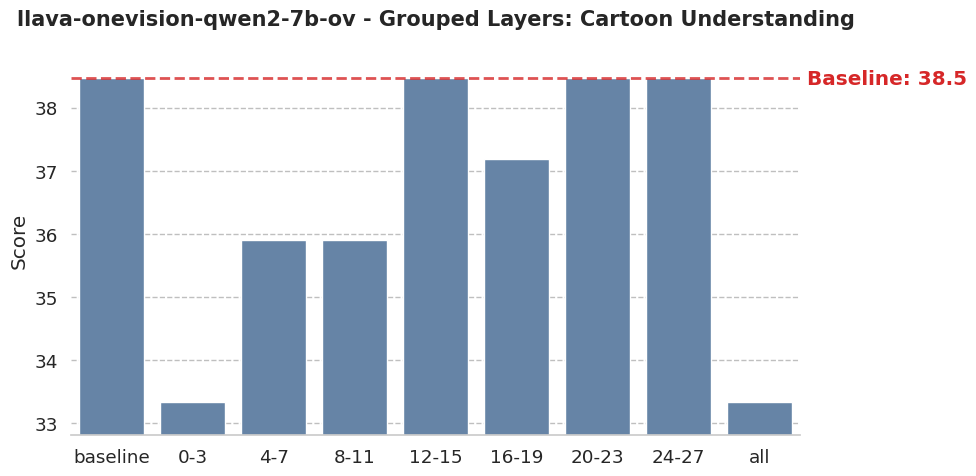

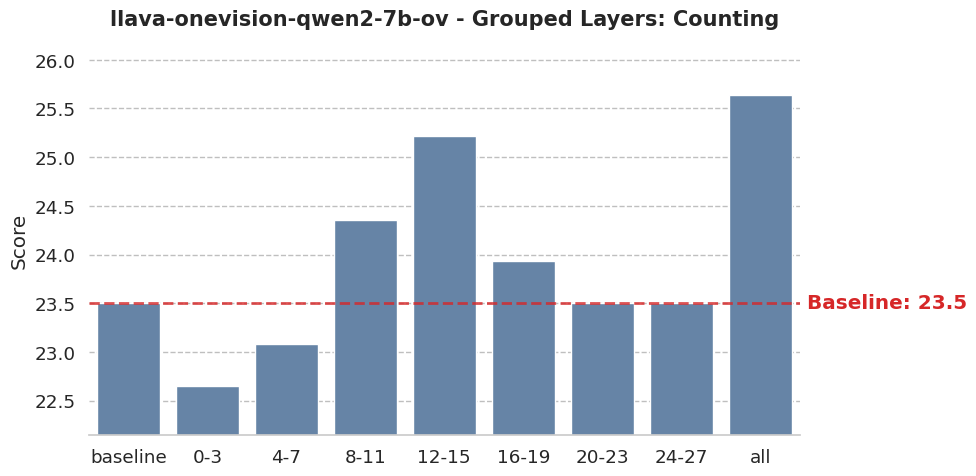

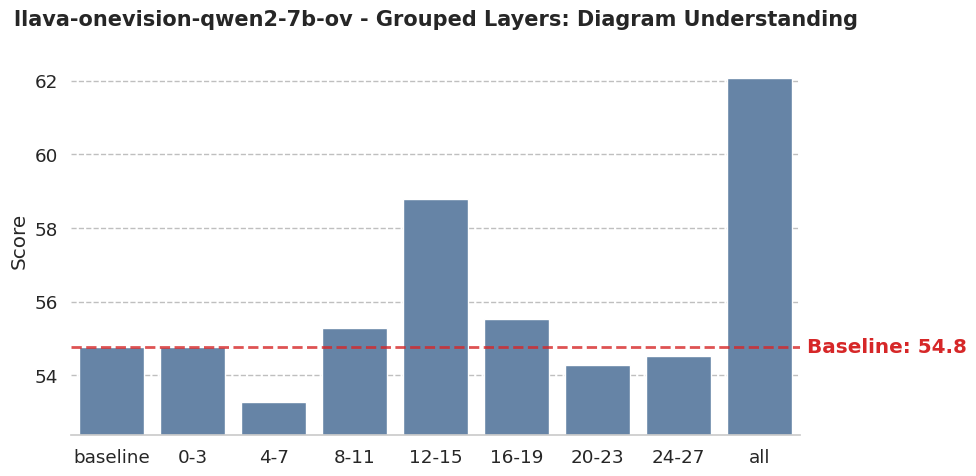

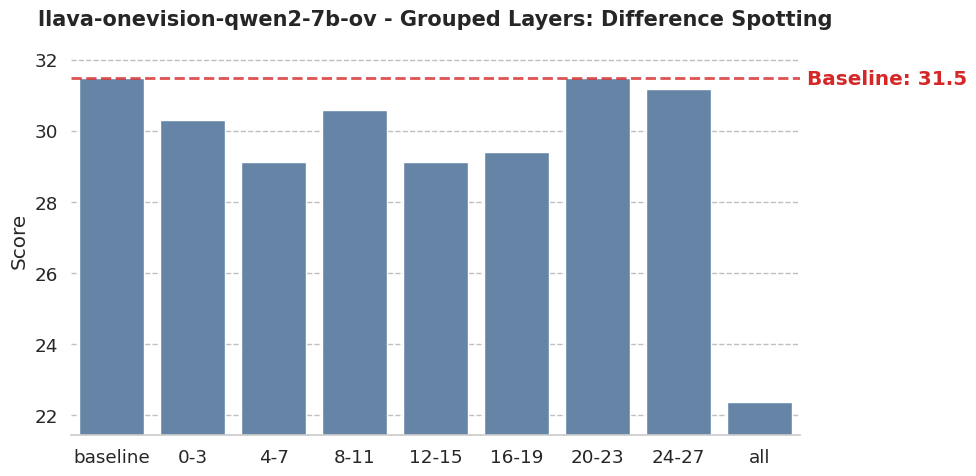

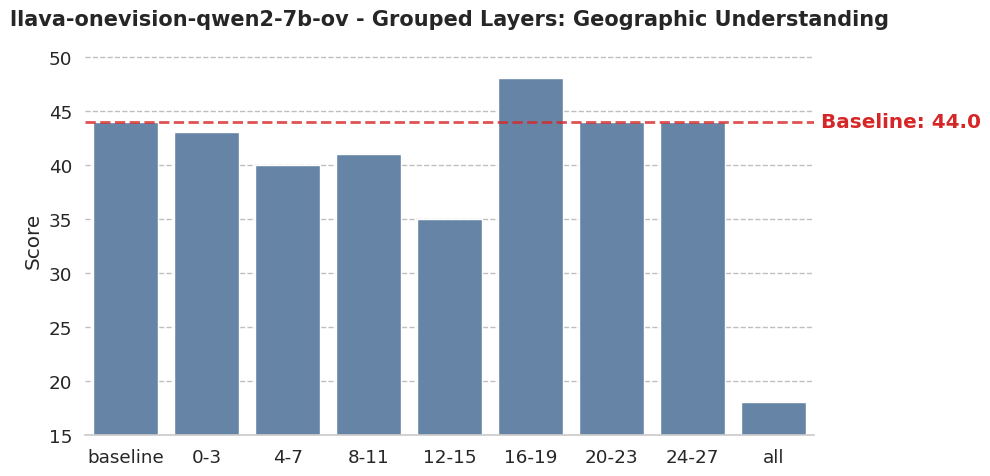

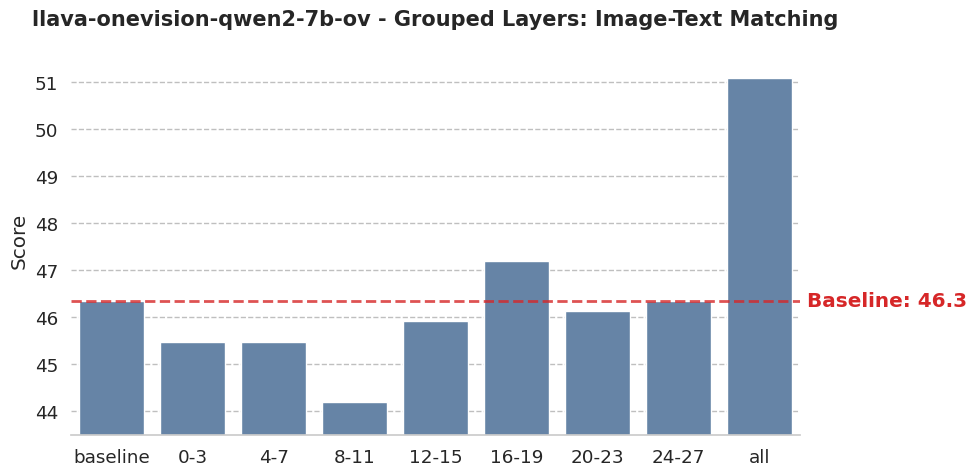

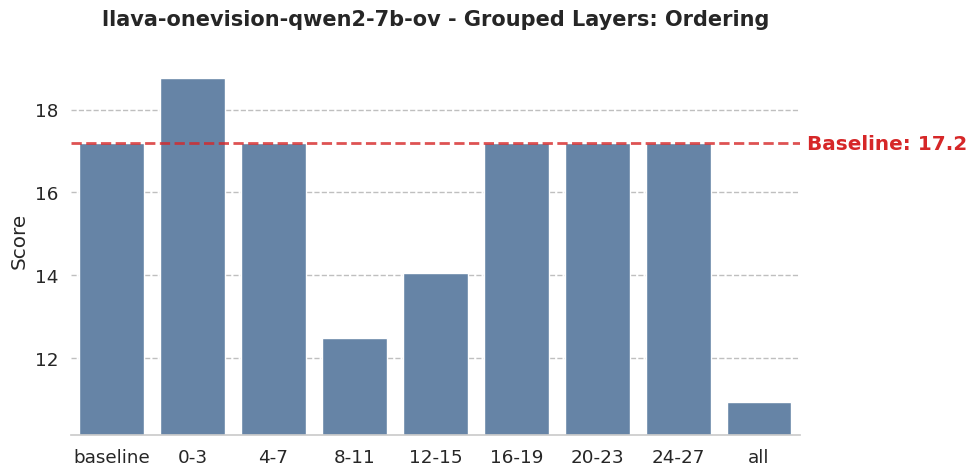

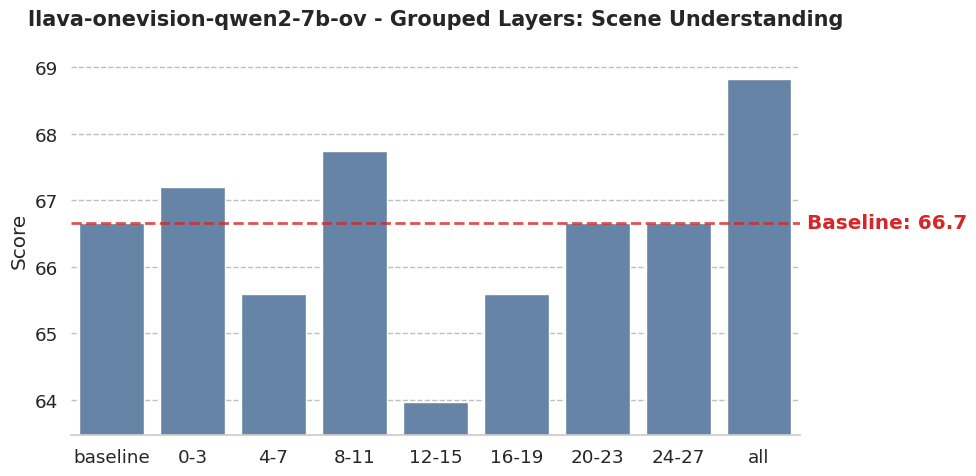

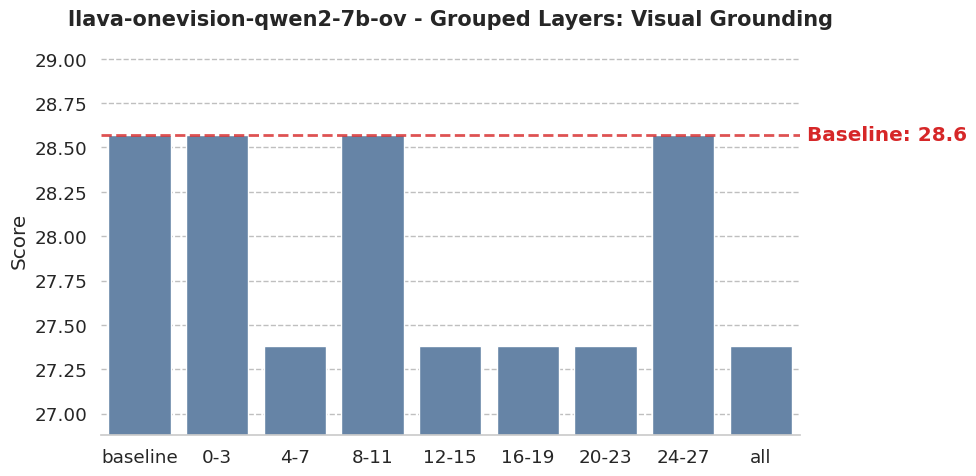

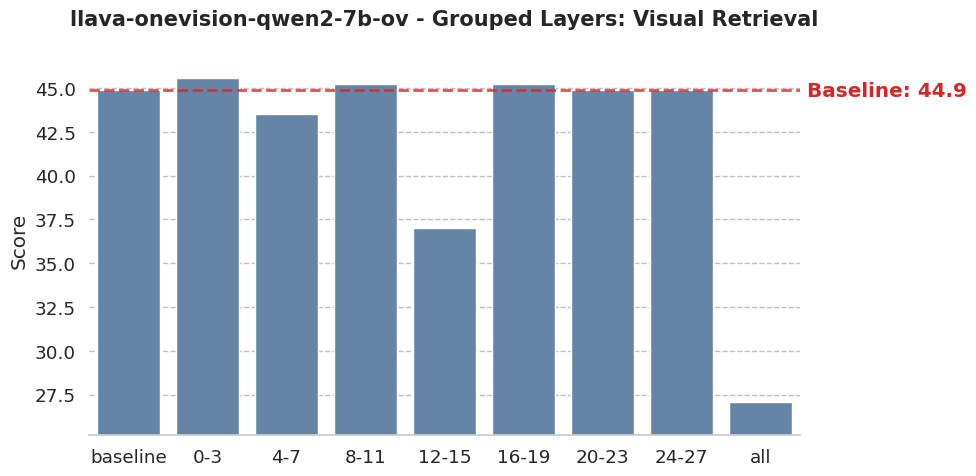

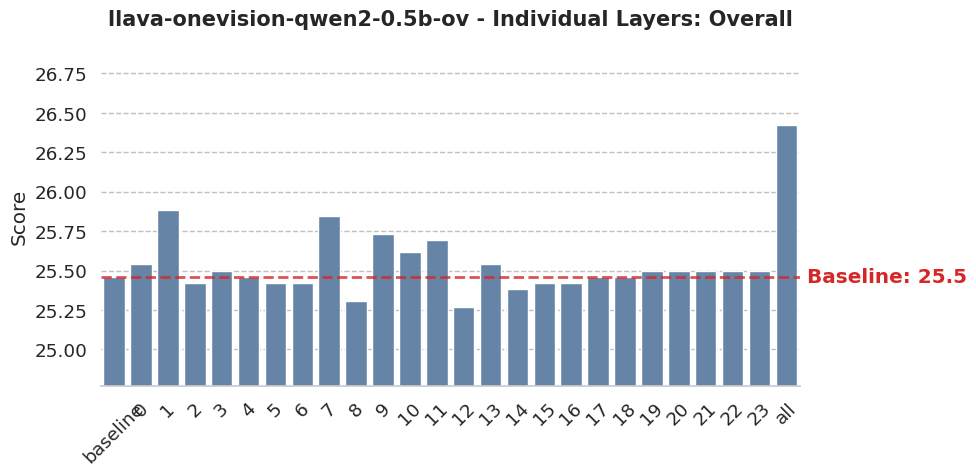

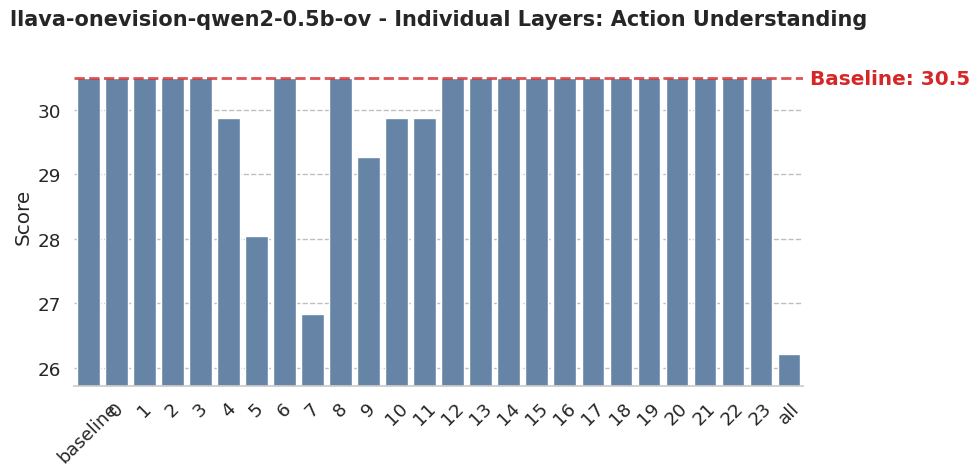

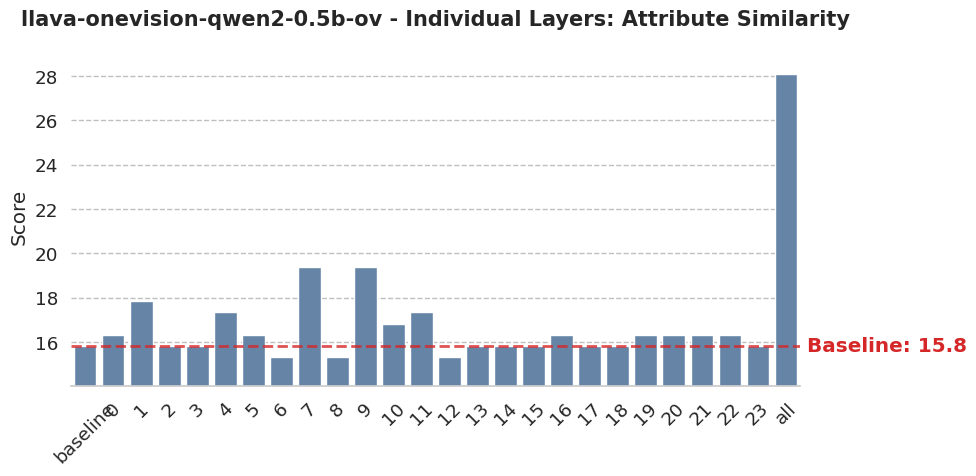

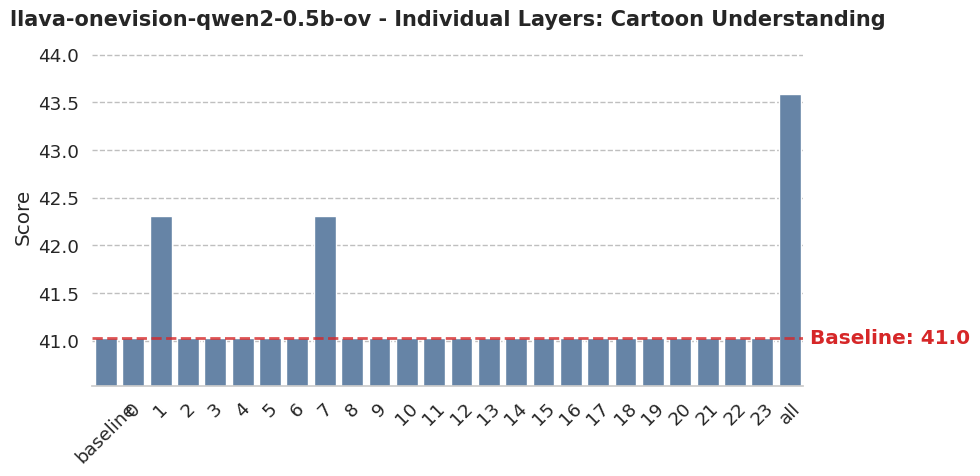

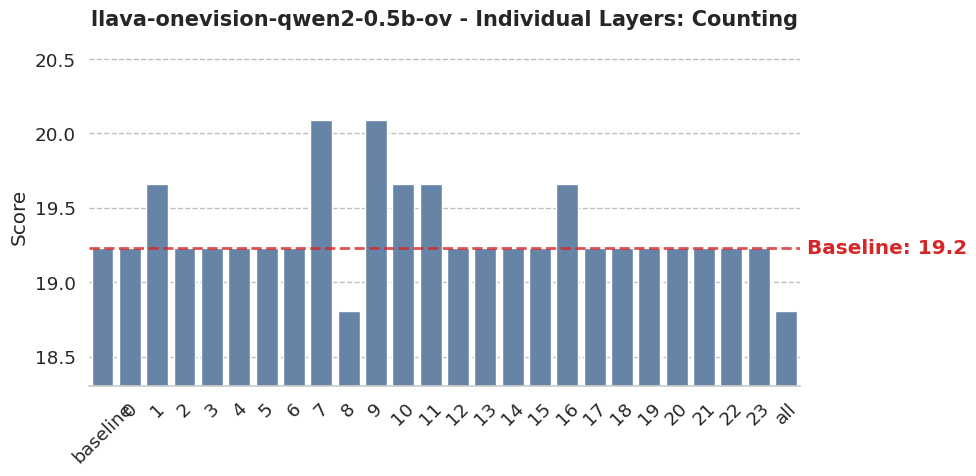

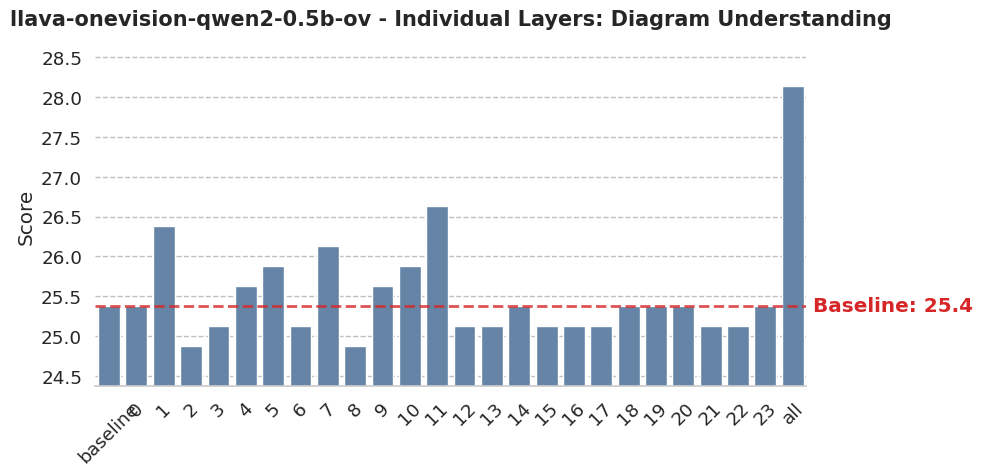

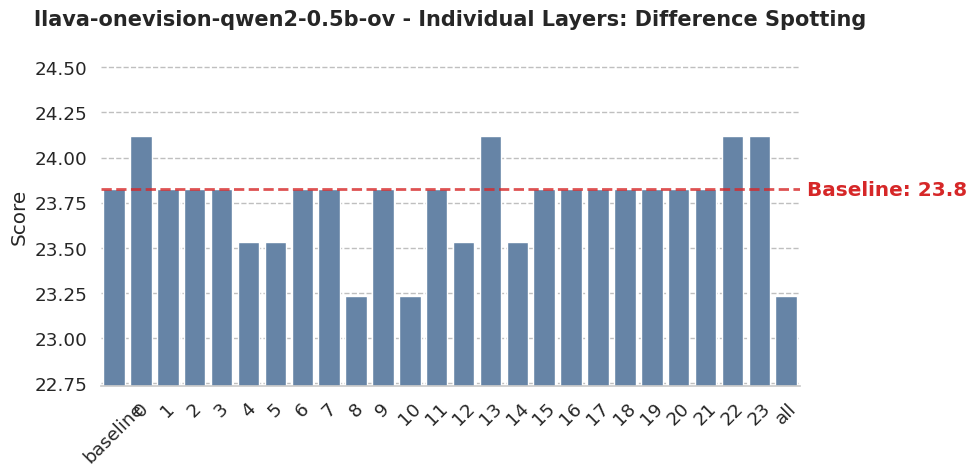

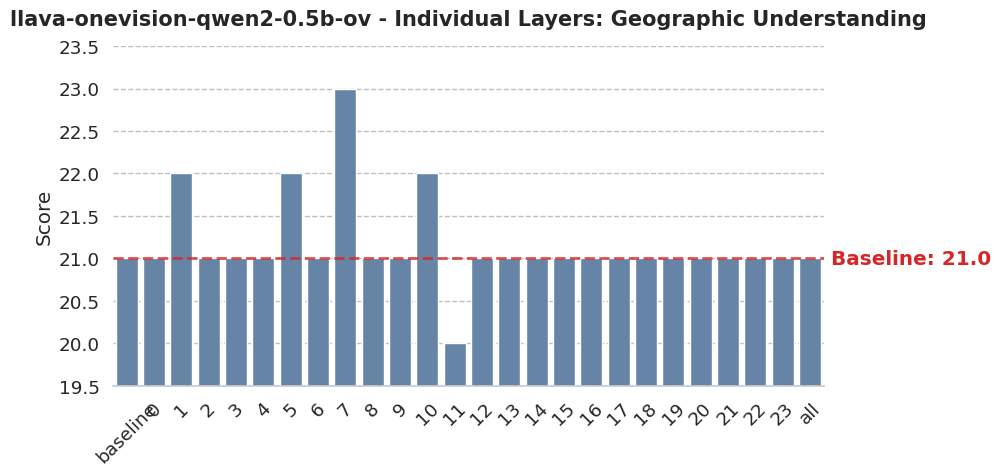

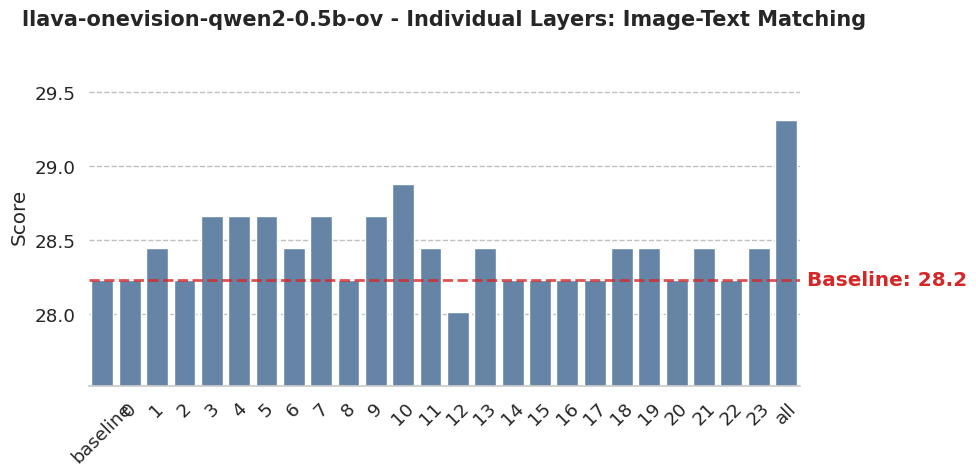

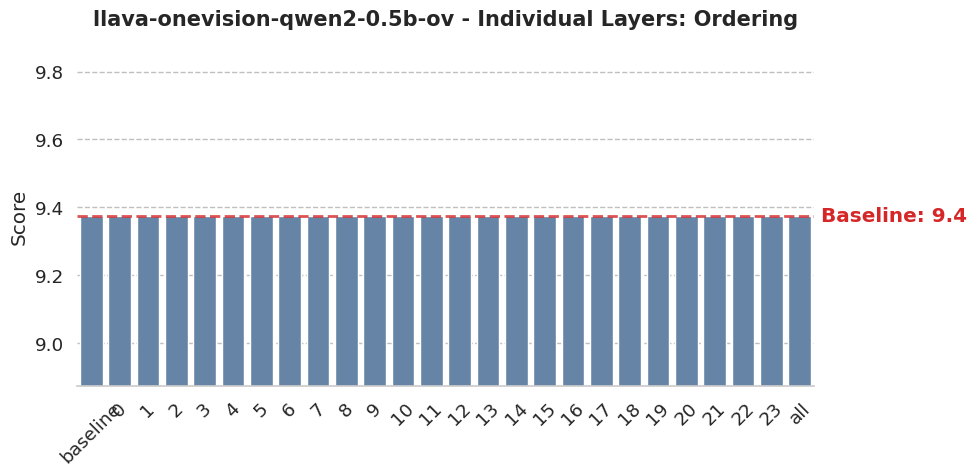

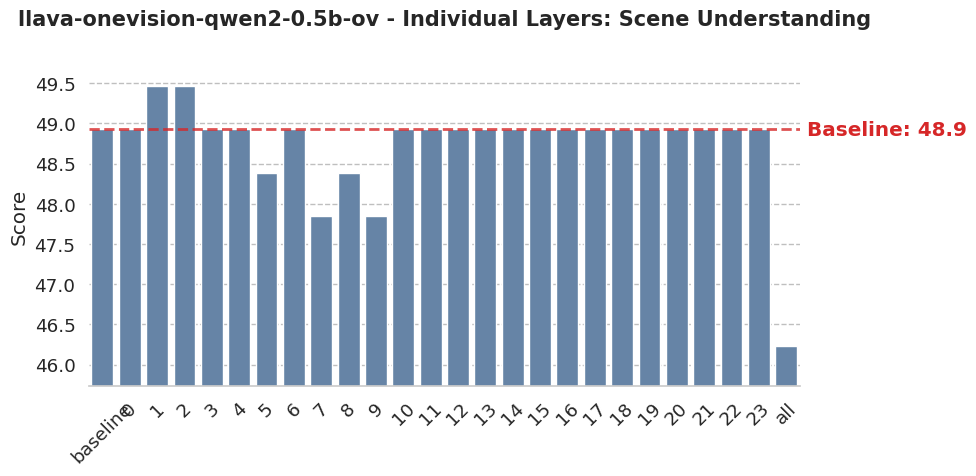

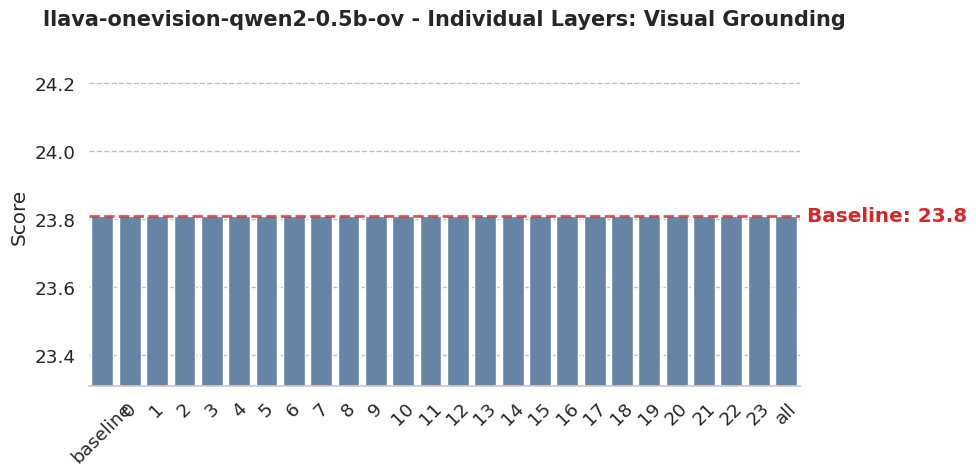

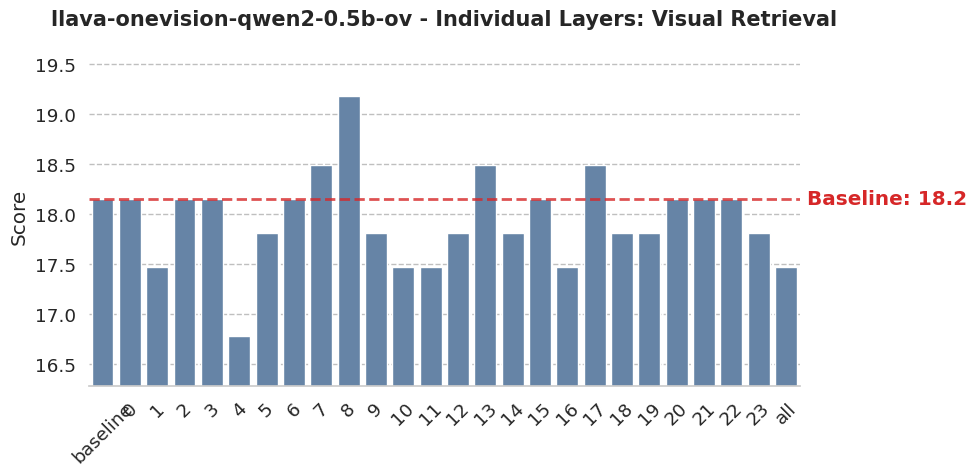

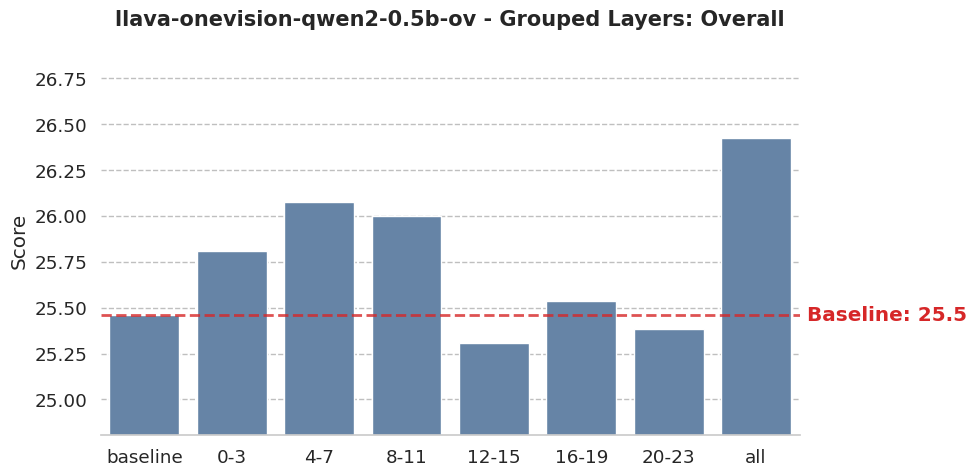

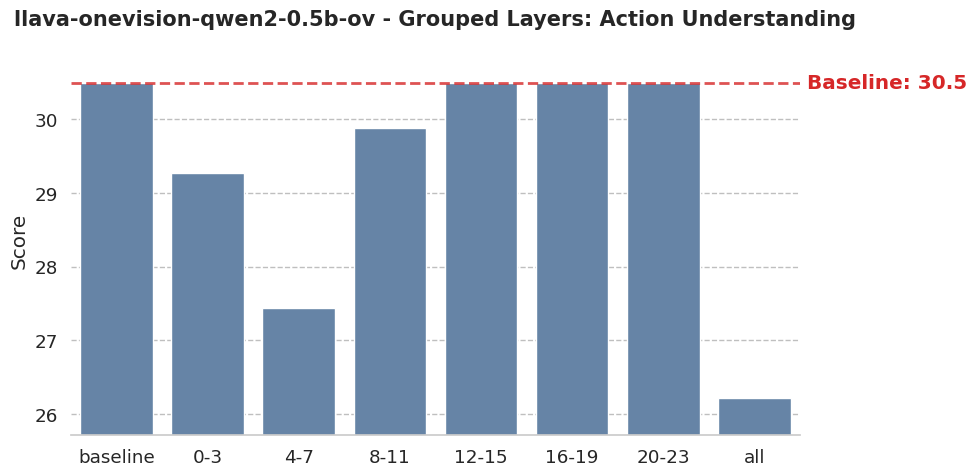

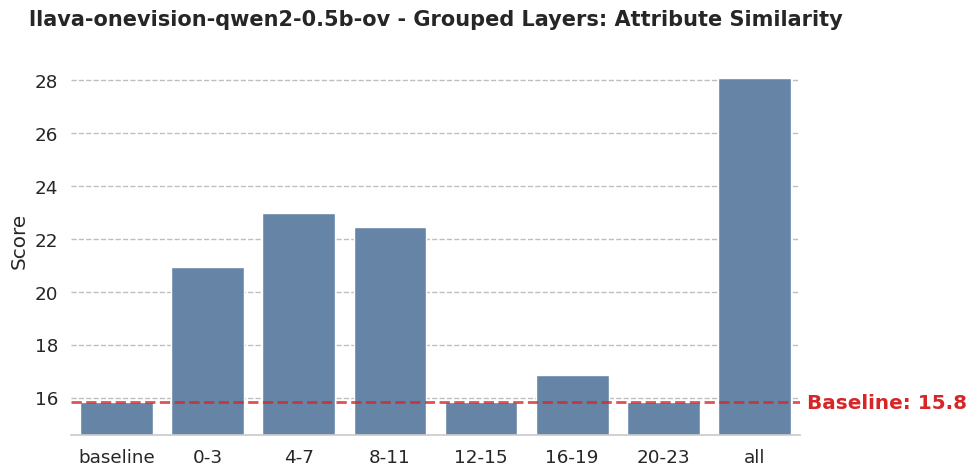

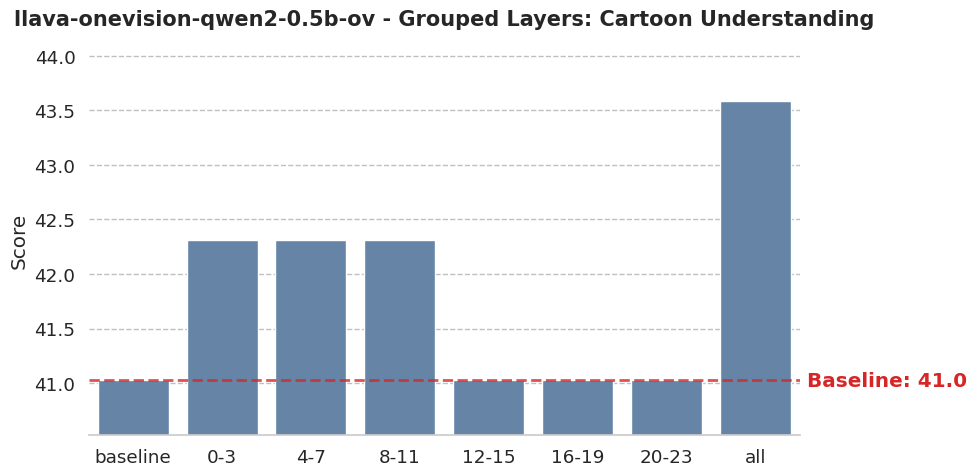

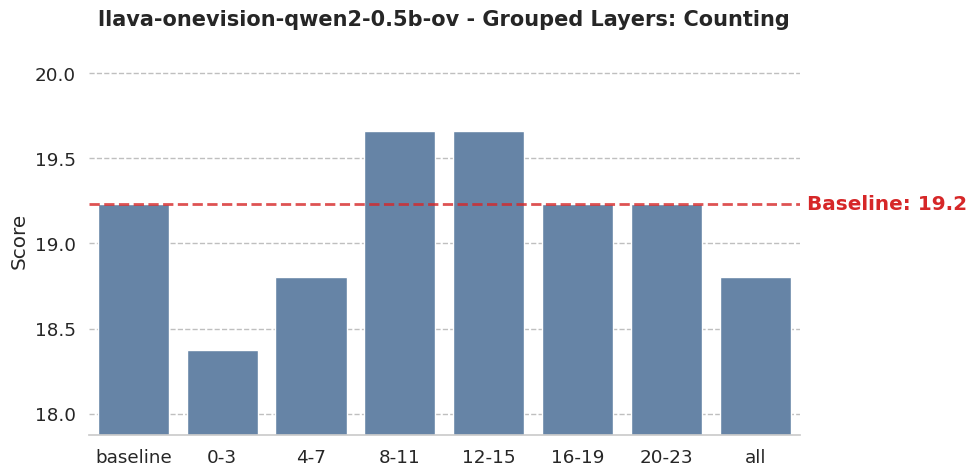

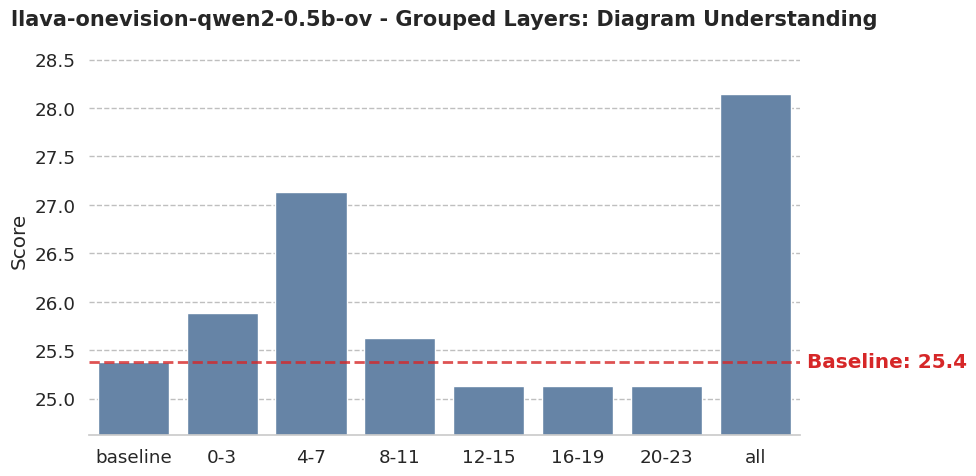

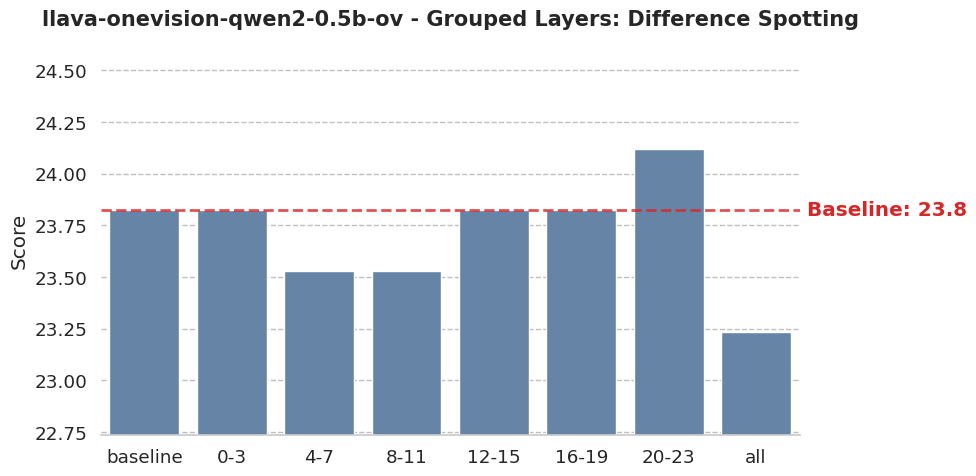

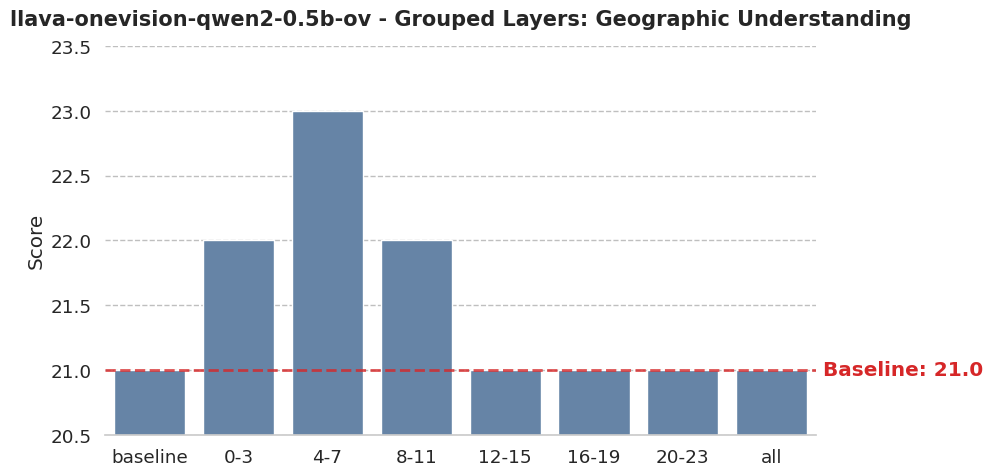

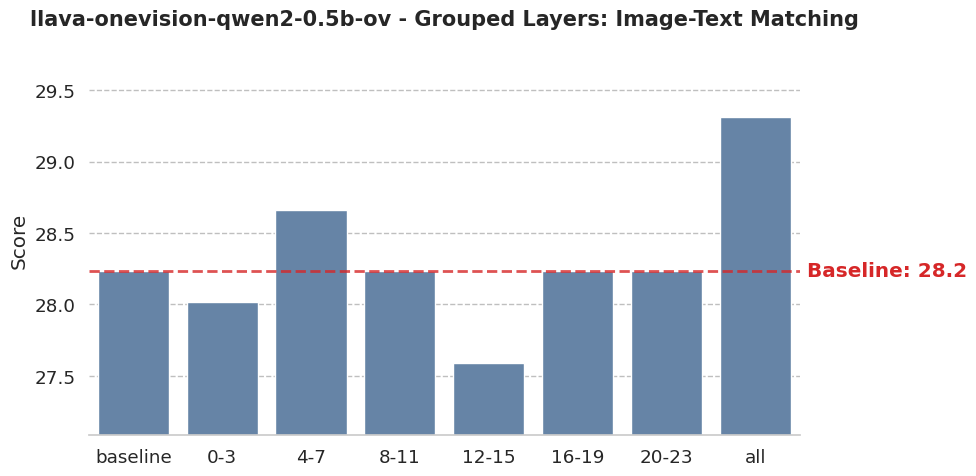

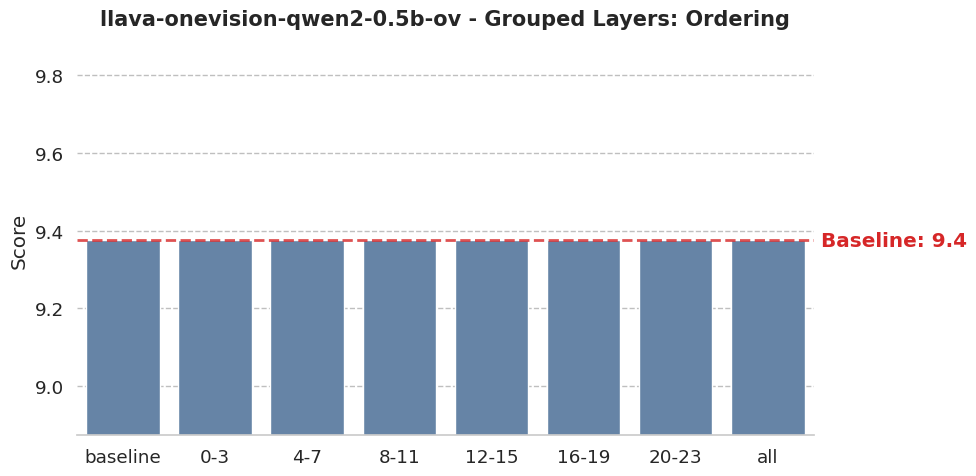

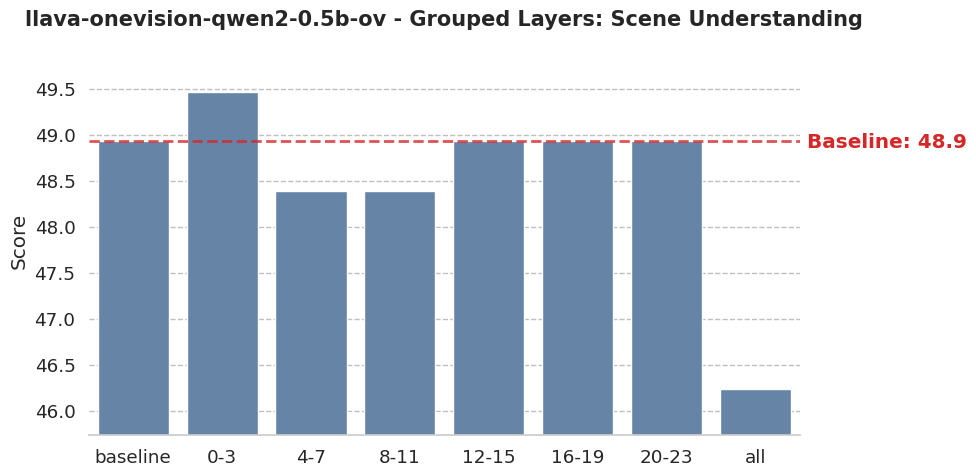

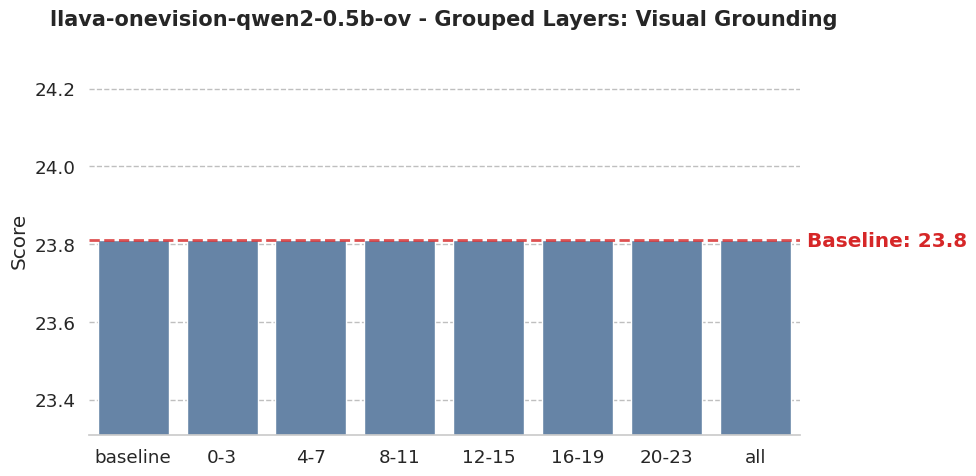

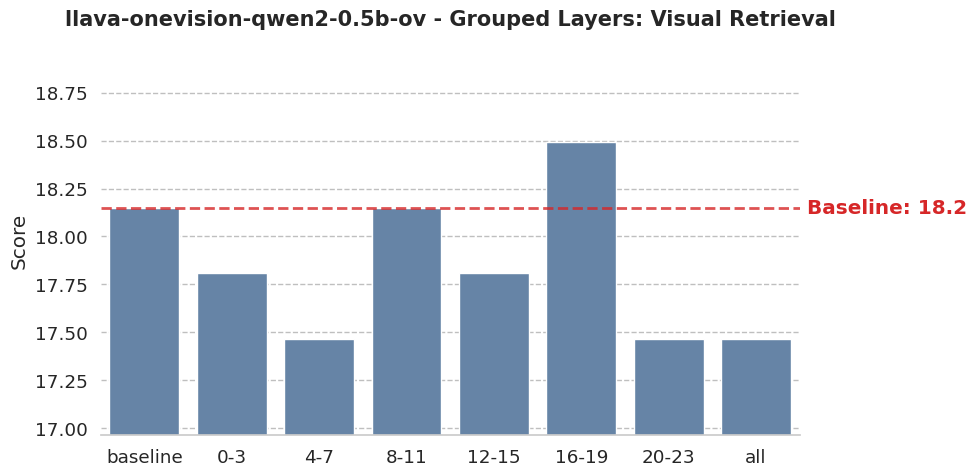

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ==========================================
# MUIRBENCH PLOTTING (Per Subtask)
# ==========================================

# 1. Prepare Dataframe from the gathered rows
if muir_rows:
    df_muir = pd.DataFrame(muir_rows)
else:
    df_muir = pd.DataFrame()

if not df_muir.empty:

    # --- Configuration ---
    sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2)
    
    # Identify all subtask columns (excluding metadata)
    meta_cols = ['Model', 'Masked Layers']
    subtasks = [c for c in df_muir.columns if c not in meta_cols]
    
    # Ensure 'Overall' is processed first if present
    if 'Overall' in subtasks:
        subtasks.remove('Overall')
        subtasks = ['Overall'] + sorted(subtasks)
    else:
        subtasks = sorted(subtasks)

    # --- Sorting Logic ---
    def get_sort_key(val):
        s_val = str(val).strip().lower()
        if 'baseline' in s_val: return (0, -1)   # Priority 0: Baseline
        if s_val == 'all': return (3, 999)       # Priority 3: All (Last)
        
        # Check for Range (e.g. "0-3")
        if '-' in s_val:
            try:
                start = int(s_val.split('-')[0])
                return (2, start)                # Priority 2: Ranges
            except: pass
            
        # Check for Single Integer (e.g. "0")
        if s_val.isdigit():
            return (1, int(s_val))               # Priority 1: Singles
            
        return (4, 0)

    df_muir['sort_key'] = df_muir['Masked Layers'].apply(get_sort_key)

    # --- Plotting Loop ---
    unique_models = df_muir['Model'].unique()

    for model in unique_models:
        model_df = df_muir[df_muir['Model'] == model].copy()

        # Create two subsets
        # 1. Individual Layers: Baseline + Singles (Priority 1) + All
        mask_singles = model_df['sort_key'].apply(lambda x: x[0] in [0, 1, 3])
        df_singles = model_df[mask_singles].sort_values('sort_key')

        # 2. Grouped Layers: Baseline + Ranges (Priority 2) + All
        mask_ranges = model_df['sort_key'].apply(lambda x: x[0] in [0, 2, 3])
        df_ranges = model_df[mask_ranges].sort_values('sort_key')

        datasets = [
            (df_singles, "Individual Layers"),
            (df_ranges, "Grouped Layers")
        ]

        for data, subtitle in datasets:
            # Skip if insufficient data (e.g. only baseline available)
            if len(data) <= 1: continue

            # Create a SEPARATE figure for each subtask
            for task in subtasks:
                
                # Check if this task actually has data for this model (ignore all-NaN columns)
                if data[task].isna().all():
                    continue

                plt.figure(figsize=(10, 5))
                
                # 1. Extract Baseline Value
                baseline_row = data[data['Masked Layers'].astype(str).str.contains('Baseline', case=False)]
                baseline_val = baseline_row[task].values[0] if not baseline_row.empty else None

                # 2. Draw Bar Chart
                ax = sns.barplot(
                    data=data,
                    x='Masked Layers',
                    y=task,
                    color='#5b84b1',  # Clean blue
                    edgecolor=None
                )

                # 3. Add Horizontal Baseline Line
                if baseline_val is not None and not np.isnan(baseline_val):
                    plt.axhline(y=baseline_val, color='#d62728', linestyle='--', linewidth=2, alpha=0.8, zorder=5)
                    plt.text(x=len(data)-0.5, y=baseline_val, s=f' Baseline: {baseline_val:.1f}', 
                             color='#d62728', va='center', ha='left', fontweight='bold')

                # 4. Smart Y-Axis Limits (Zoom in)
                y_values = data[task].dropna().values
                if len(y_values) > 0:
                    y_min = y_values.min()
                    y_max = y_values.max()
                    
                    if baseline_val is not None and not np.isnan(baseline_val):
                        y_min = min(y_min, baseline_val)
                        y_max = max(y_max, baseline_val)
                    
                    y_range = y_max - y_min
                    # Add margin: 10% of range, or minimal 0.5 if range is tiny
                    margin = max(y_range * 0.1, 0.5)
                    
                    # Ensure we don't go below 0
                    lower_lim = max(0, y_min - margin)
                    upper_lim = y_max + margin
                    
                    plt.ylim(lower_lim, upper_lim)

                # 5. Styling
                model_name = model.split("__")[1]
                plt.title(f"{model_name} - {subtitle}: {task}", fontsize=15, fontweight='bold', pad=15)
                plt.xlabel('')
                plt.ylabel('Score')
                sns.despine(left=True)
                plt.grid(axis='y', linestyle='--', alpha=0.5, color='gray')
                plt.grid(axis='x', visible=False)
                
                # Rotate labels for individual layers to prevent overlap
                if 'Individual' in subtitle:
                    plt.xticks(rotation=45)

                plt.tight_layout()
                plt.show()
else:
    print("No MuirBench data found to plot.")

In [10]:
import json
import glob
import os
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================

LOG_DIRECTORIES ="/lustre/groups/eml/projects/huang/multi_image/lmms-eval/logs/llava-ov-mask-attention"

# ==========================================
# 2. EVALUATION LOGIC (MMMU / MIRB Style)
# ==========================================

def normalize_str(s):
    """
    Approximation of MMMU normalize_str.
    Returns a list containing the normalized value (float or string).
    """
    if s is None:
        return []
    
    # Try converting to float first
    try:
        return [float(s)]
    except ValueError:
        pass
    
    # Otherwise normalize string
    if isinstance(s, str):
        return [s.strip().lower()]
    return [str(s)]

def eval_multi_choice(gold_i, pred_i):
    """
    Evaluate a multiple choice instance.
    https://github.com/MMMU-Benchmark/MMMU/blob/51ce7f3e829c16bb44bc5445782686b4c3508794/eval/eval_utils.py#L175
    """
    correct = False
    # only they are exactly the same, we consider it as correct
    if isinstance(gold_i, list):
        for answer in gold_i:
            if answer == pred_i:
                correct = True
                break
    else:  # gold_i is a string
        if gold_i == pred_i:
            correct = True
    return correct


def eval_open(gold_i, pred_i):
    """
    Evaluate an open question instance
    https://github.com/MMMU-Benchmark/MMMU/blob/51ce7f3e829c16bb44bc5445782686b4c3508794/eval/eval_utils.py#L191
    """
    correct = False
    if isinstance(gold_i, list):
        # use float to avoid trivial matches
        norm_answers = []
        for answer in gold_i:
            norm_answers.extend(normalize_str(answer))
    else:
        norm_answers = normalize_str(gold_i)
    for pred in pred_i:  # pred is already normalized in parse response phase
        if isinstance(pred, str):  # if it's a string, then find if ans in the pred_i
            for norm_ans in norm_answers:
                # only see if the string answer in the string pred
                if isinstance(norm_ans, str) and norm_ans in pred:
                    if not correct:
                        correct = True
                    break
        else:  # it's a float number
            if pred in norm_answers:
                if not correct:
                    correct = True
                break
    return correct

def parse_mirb_advanced(file_path):
    stats = {}
    total_correct = 0
    total_count = 0
    
    try:
        with open(file_path, 'r') as f:
            for line in f:
                entry = json.loads(line)
                info = entry.get('mirb_score', {})
                if not info: continue
                
                subset = info.get('subset', 'Unknown')
                pred_answer = info.get('pred_answer', [])
                answers = info.get('answers', '')
                
                # --- DETERMINE EVALUATION METHOD ---
                # Logic: If answer is single letter A-E, treat as MCQ
                is_mcq = False
                if isinstance(answers, str) and answers.strip().upper() in ["A", "B", "C", "D", "E"]:
                    is_mcq = True
                
                # --- EVALUATE ---
                if is_mcq:
                    is_correct = eval_multi_choice(answers, pred_answer)
                else:
                    is_correct = eval_open(answers, pred_answer)
                
                # --- UPDATE STATS ---
                if subset not in stats: stats[subset] = {'c': 0, 't': 0}
                stats[subset]['t'] += 1
                if is_correct: stats[subset]['c'] += 1
                
                total_count += 1
                if is_correct: total_correct += 1
                
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return None
        
    # Calculate Percentages
    results = {k: (v['c'] / v['t'] * 100) for k, v in stats.items()}
    results['Overall'] = (total_correct / total_count * 100) if total_count > 0 else 0.0
    
    return results

# ==========================================
# 3. MAIN EXECUTION
# ==========================================

mirb_rows = []

results_files = glob.glob(os.path.join(LOG_DIRECTORIES, "**", "*_results.json"), recursive=True)
    
for res_file in results_files:
    dir_name = os.path.dirname(res_file)
    base_name = os.path.basename(res_file).replace('_results.json', '')
    
    try:
        with open(res_file, 'r') as f:
            meta = json.load(f)
            model_name = meta.get('model_name_sanitized', meta.get('model_name', 'Unknown'))
    except:
        continue
        
    # Process MIRB with Advanced Logic
    mirb_path = os.path.join(dir_name, f"{base_name}_samples_mirb.jsonl")
    layer = mirb_path.split("/")[-3].split("-mask-attention-")[-1]
    if os.path.exists(mirb_path):
        scores = parse_mirb_advanced(mirb_path)
        if scores:
            row = {'Model': model_name, 'Masked Layers': layer}
            row.update(scores)
            mirb_rows.append(row)

# ==========================================
# 4. DISPLAY TABLE
# ==========================================

if mirb_rows:
    df_mirb = pd.DataFrame(mirb_rows)
    
    # Sort Rows
    df_mirb = df_mirb.sort_values(by=['Model', 'Masked Layers']).reset_index(drop=True)
    
    # Sort Columns (Overall first, then alphabetical)
    meta = ['Model', 'Masked Layers']
    others = [c for c in df_mirb.columns if c not in meta]
    
    if 'Overall' in others:
        others.remove('Overall')
        cols = meta + ['Overall'] + sorted(others)
    else:
        cols = meta + sorted(others)
        
    print("\n### 4. MIRB Subset Breakdown (Corrected Evaluation)")
    display(
        df_mirb[cols].style.format(precision=1, na_rep="-")
        .background_gradient(cmap='Blues', subset=cols[2:])
        .set_properties(**{'text-align': 'center'})
    )
else:
    print("No MIRB data found.")


### 4. MIRB Subset Breakdown (Corrected Evaluation)
